In [ ]:
!pip install scikit-learn==1.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
import random
import os

np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

!pip install CatBoost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00


In [ ]:
!pip install category_encoders
from sklearn.linear_model import (
    LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge, ARDRegression,
    PassiveAggressiveRegressor, HuberRegressor, TheilSenRegressor, RANSACRegressor
)
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
    BaggingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, StackingRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from tqdm import tqdm  # Progress bar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 3.3 MB/s eta 0:00:00


# 1 Functions


## A/ Creation

### create_df

In [ ]:
def create_df(path):
    df = pd.read_csv(path)
    return df

### numerical / categorical columns

In [ ]:
def get_num_cat_columns(df) -> dict:
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    return {"numerical" : numerical_columns, "categorical" : categorical_columns}

### nulls_summary_table

In [ ]:
def nulls_summary_table(df):
    null_values = pd.DataFrame(df.isnull().sum())
    null_values[1] = null_values[0]/len(df)
    null_values.columns = ['null_count','null_percentage']
    return null_values

## B/ Transformations

### Drop columns

In [ ]:
def drop_columns(df, columns):
    dropped = df.copy()
    dropped = dropped.drop(columns, axis=1)
    return dropped

### drop_null_values


In [ ]:
def drop_null_values(df):
    dropped = df.copy()
    dropped = dropped.dropna()
    return dropped

def drop_null_values_columns(df, columns):
    dropped = df.copy()
    dropped = dropped.dropna(subset=columns)
    return dropped

### Mean/Median/Mode Imputation

In [ ]:
def mean_median_mode_imputation(df, columns, option = "mean"):
  imputed_df = df.copy()
  for column in columns:
    if option == 'mean':
      imputed_df[column] = imputed_df[column].fillna(np.ceil(imputed_df[column].mean()))
    elif option == 'median':
      imputed_df[column] = imputed_df[column].fillna(imputed_df[column].median())
    elif option == 'mode':
      imputed_df[column] = imputed_df[column].fillna(imputed_df[column].mode()[0])

  return imputed_df

### Custom fill_na

In [ ]:
def fill_weekend(df):
    df = df.copy()
    df['weekend'] = df['weekend'].fillna((df['date'].dt.weekday >= 5).astype(int))
    return df

def impute_jour_ferie_mode(df):
    jour_ferie_df = df.copy()
    # Fill NaN values in 'jour_ferie' by the mode (most frequent value) within each group of 'date'
    jour_ferie_df['jour_ferie'] = jour_ferie_df.groupby('date')['jour_ferie'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))
    return jour_ferie_df

def impute_jour_ferie(df):
  jf = df.copy()
  jf['date'] = pd.to_datetime(jf['date'])  # Ensure 'date' is in datetime format
  # Step 1: Extract unique (day, month) -> jour_ferie mapping
  mapping_df = jf.dropna(subset=['jour_ferie'])[jf["jour_ferie"] == 1]  # Only use rows where 'jour_ferie' is not NaN
  jour_ferie_map = dict(zip(
      zip(mapping_df['date'].dt.day, mapping_df['date'].dt.month),
      mapping_df['jour_ferie']
  ))

  jf['jour_ferie'] = jf.apply(
      lambda row: jour_ferie_map.get((row['date'].day, row['date'].month), 0),
      axis=1
  )
  return jf


def impute_promotion_mode(df):
    promotion_df = df.copy()
    # Fill NaN values in 'promotion' by the mode (most frequent value) within each group of 'date'
    promotion_df['promotion'] = promotion_df.groupby('date')['promotion'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))
    return promotion_df

def impute_promotion(df):
  promo = df.copy()
  # Ensure 'date' is in datetime format
  promo['date'] = pd.to_datetime(promo['date'], errors='coerce')

  # Step 1: Add 'day' and 'month' columns
  promo['day'] = promo['date'].dt.day
  promo['month'] = promo['date'].dt.month

  # Step 2: Extract the mapping for (day, month, jour_ferie) -> promotion
  promo_mapping = promo.dropna(subset=['promotion']).groupby(['day', 'month', 'jour_ferie'])['promotion'].max()
  promo_mapping = promo_mapping.to_dict()

  # Step 3: Impute missing 'promotion' using the mapping
  promo['promotion'] = promo.apply(
      lambda row: promo_mapping.get((row['day'], row['month'], row['jour_ferie']), 0)
      if pd.isna(row['promotion']) else row['promotion'],
      axis=1
  )
  return promo

def impute_meteo(df):
    meteo_df = df.copy()

    # Group by 'region' and 'moment_journee', and fill missing values using the mode
    meteo_df['condition_meteo'] = meteo_df.groupby(['date', 'region', 'moment_journee'])['condition_meteo'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

    return meteo_df


def impute_moment_journee(df):
    moment_journee_df = df.copy()
    # Fill NaN values in 'moment_journee' by the mode (most frequent value) within each group of 'date'
    moment_journee_df['moment_journee'] = moment_journee_df.groupby(['date', 'condition_meteo'])['moment_journee'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))
    return moment_journee_df

def impute_column_randomly(df, column):
    # Get non-null values from the column
    non_null_values = df[column].dropna().values

    # Check if there are any non-null values to sample from
    if len(non_null_values) == 0:
        raise ValueError(f"No non-null values to sample from in column '{column}'.")

    # Randomly sample values for missing entries
    missing_indices = df[column].isna()
    df.loc[missing_indices, column] = np.random.choice(non_null_values, size=missing_indices.sum(), replace=True, random_state=42)

    return df





### Imputations using ML

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor

def ML_impute(df, option):
    df_imputed = df.copy()
    random_state = 42

    if option == "knn":
        # KNNImputer
        imputer = KNNImputer(n_neighbors=10)
        df_imputed[:] = imputer.fit_transform(df)

    elif option == "iterative":
        # IterativeImputer
        imputer = IterativeImputer(max_iter=10, random_state=random_state)
        df_imputed[:] = imputer.fit_transform(df)

    elif option == "random_forest":
        # Custom Imputer using Random Forest for numeric columns
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                # Separate known and unknown values
                train_data = df.loc[df[col].notnull()]
                test_data = df.loc[df[col].isnull()]

                X_train = train_data.drop(columns=[col])
                y_train = train_data[col]
                X_test = test_data.drop(columns=[col])

                if X_train.empty or X_test.empty: continue  # Skip if no data

                # Train RandomForestRegressor
                rf = RandomForestClassifier(random_state=random_state)
                rf.fit(X_train, y_train)
                preds = rf.predict(X_test)

                # Fill missing values
                df_imputed.loc[df[col].isnull(), col] = preds

    elif option == "mlp":
        # Custom Imputer using MLPRegressor (Neural Network) for numeric columns
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                train_data = df.loc[df[col].notnull()]
                test_data = df.loc[df[col].isnull()]

                X_train = train_data.drop(columns=[col])
                y_train = train_data[col]
                X_test = test_data.drop(columns=[col])

                if X_train.empty or X_test.empty: continue  # Skip if no data

                # Train MLPRegressor
                mlp = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500, random_state=random_state)
                mlp.fit(X_train, y_train)
                preds = mlp.predict(X_test)

                # Fill missing values
                df_imputed.loc[df[col].isnull(), col] = preds

    else:
        raise ValueError("Invalid option. Choose from 'simple', 'knn', 'iterative', 'random_forest', or 'mlp'.")

    return df_imputed


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

def impute_nums_ml(df, target_col, predictor_cols, model_type='linear'):
    """
    Impute missing values in a target column using a predictive model,
    ensuring predictors have no missing values.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        target_col (str): The column with missing values to be imputed.
        predictor_cols (list): List of columns to use as predictors.
        model_type (str): Type of model ('linear' or 'random_forest').

    Returns:
        pd.DataFrame: DataFrame with imputed values for the target column.
    """
    df = df.copy()

    # Separate rows where target_col is not null (training) and null (to impute)
    train_data = df[df[target_col].notna()]
    test_data = df[df[target_col].isna()]

    # Drop rows with missing predictors in training data
    train_data = train_data.dropna(subset=predictor_cols)

    # Features and target for training
    X_train = train_data[predictor_cols]
    y_train = train_data[target_col]

    # Drop rows with missing predictors in test data
    X_test = test_data[predictor_cols].dropna()

    # Check if X_train or X_test are empty
    if X_train.empty or X_test.empty:
        print(f"No sufficient data for training or predicting {target_col}")
        return df

    # Initialize the model
    if model_type == 'linear':
        model = LinearRegression()
    elif model_type == 'random_forest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'xgboost':
        model = XGBRegressor(n_estimators=100, random_state=42)
    else:
        raise ValueError("Invalid model_type. Use 'linear' or 'random_forest'.")

    # Train the model
    model.fit(X_train, y_train)

    # Predict missing values
    predicted_values = model.predict(X_test)
    print(f"number of predicted values {len(predicted_values)}")

    # Fill missing values in the target column
    df.loc[X_test.index, target_col] = predicted_values

    print(f"Missing values in '{target_col}' have been imputed using {model_type} model.")
    return df

import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def impute_catrgories_ml(df, target, predictors):
    """
    Impute missing values in a categorical column using ML classification (without encoding).

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    target (str): The name of the target column (categorical with missing values).
    predictors (list): List of predictor column names.

    Returns:
    pd.DataFrame: DataFrame with imputed target column values.
    """
    # Ensure that 'marque' is treated as a categorical column
    df[predictors] = df[predictors].astype(str)  # Convert to string type

    # Separate rows with and without the target value
    train_data = df[df[target].notna()].copy()
    test_data = df[df[target].isna()].copy()

    # Features and target
    X = train_data[predictors]  # Features (no encoding, raw data)
    y = train_data[target]  # Target column (no encoding, raw data)
    X_missing = test_data[predictors]  # Features for rows with missing target

    # Train-test split
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train CatBoost Classifier (handles categorical features natively)
    model = CatBoostClassifier(iterations=50, depth=6, learning_rate=0.01, verbose=200)
    model.fit(X_train, y_train)

    # Evaluate model
    y_pred = model.predict(X_valid)
    # print("Model Evaluation:\n")
    # print(classification_report(y_valid, y_pred))

    # Predict missing values
    if not X_missing.empty:
        test_data[target] = model.predict(X_missing).ravel()
        # Merge back into the original DataFrame
        df.loc[df[target].isna(), target] = test_data[target]

    return df



### a/ Encoding

#### One Hot encoding

In [ ]:
def one_hot_encode(df, columns, drop_f=False):
    encoded_df = df.copy()

    # Perform one-hot encoding
    encoded_df = pd.get_dummies(encoded_df, columns=columns, drop_first=drop_f, dtype=int)

    # Identify new columns (those that were added by the one-hot encoding process)
    new_columns = [col for col in encoded_df.columns if col not in df.columns]
    print(new_columns)

    return encoded_df, new_columns


#### Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

def label_encode(df, columns):
    encoded_df = df.copy()
    label_encoder = LabelEncoder()
    for col in columns:
        encoded_df[col] = label_encoder.fit_transform(encoded_df[col])
    return encoded_df

#### Ordinal Encoding

#### Target encoding

In [ ]:
def target_encode(df, columns, target):
    """
    Encode a categorical column using target encoding (mean of the target variable).

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The name of the categorical column to encode.
    target (str): The name of the target column to use for encoding.

    Returns:
    pd.DataFrame: DataFrame with the target-encoded column.
    """
    # Calculate the mean of the target variable for each category
    encoding = df.groupby(columns)[target].mean()

    # Map the encoding back to the original DataFrame
    df[columns] = df[columns].map(encoding)

    return df


#### Custom encoding

In [ ]:
'''
  encoding 'id_produit'
'''
def encode_id_produit(df):
  encoded_df = df.copy()
  tag1 = pd.DataFrame(encoded_df['id_produit'].str.split('-').str[0])
  tag2 = pd.DataFrame(encoded_df['id_produit'].str.split('-').str[1])
  tag3 = pd.DataFrame(encoded_df['id_produit'].str.split('-').str[2])

  tag1 = label_encode(tag1, ["id_produit"])
  encoded_df.loc[:, 'id_produit'] = (tag1['id_produit'].astype(str) +
                                     tag2['id_produit'].astype(str) +
                                     tag3['id_produit'].astype(str))
  encoded_df['id_produit'] = encoded_df['id_produit'].astype(int)
  return encoded_df

def frequency_encoding(df, column_name):
    """
    Perform frequency encoding on a categorical column.

    Parameters:
    - df: pandas DataFrame containing the data.
    - column_name: The name of the column to encode.

    Returns:
    - The DataFrame with the frequency-encoded column.
    """
    # Calculate the frequency of each category in the column
    freq_encoding = df[column_name].value_counts() / len(df) * 100

    # Map the frequency encoding to the original column
    df[column_name] = df[column_name].map(freq_encoding)

    return df

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

def ordinal_encode(df, column):
    encoded_df = df.copy()
    ordinal_encoder = OrdinalEncoder()
    encoded_df[column] = ordinal_encoder.fit_transform(encoded_df[[column]])
    return encoded_df

### b/ Feature scaling

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

def feature_scaling(df, columns, option):
    scaled_df = df.copy()
    if option == "maxabs":
        scaler = MaxAbsScaler()
    elif option == "minmax":
        scaler = MinMaxScaler()
    elif option == "standard":
        scaler = StandardScaler()
    elif option == "robust":
        scaler = RobustScaler()

    scaled_df[columns] = scaler.fit_transform(scaled_df[columns])
    return scaled_df

## C/ EDA

### Box plots

In [ ]:
def show_box_plots(df, columns):
    n_cols = 3
    n_rows = (len(columns) // n_cols) + (1 if len(columns) % n_cols != 0 else 0)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]
        df[col].plot(kind='box', ax=ax)
        ax.set_title(f'Box Plot of {col}')
        ax.set_ylabel('Value')

    # Hide any unused subplots (if there are fewer columns than subplots)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

### extract_outliers

In [ ]:
def extract_outliers(df):
    ## Get IQR
    iqr_q1 = np.quantile(df, 0.25)
    iqr_q3 = np.quantile(df, 0.75)
    med = np.median(df)

    # finding the iqr region
    iqr = iqr_q3-iqr_q1

    # finding upper and lower whiskers
    upper_bound = iqr_q3+(1.5*iqr)
    lower_bound = iqr_q1-(1.5*iqr)

    outliers = df[(df <= lower_bound) | (df >= upper_bound)]
    print('Outliers within the box plot are :{}'.format(outliers))
    return outliers

### Historgram plots

In [ ]:
def show_hist_plots(df, columns):
    n_cols = 3
    n_rows = (len(columns) // n_cols) + (1 if len(columns) % n_cols != 0 else 0)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]
        sns.histplot(df[col], ax=ax)
        ax.set_title(f'Histogram of {col}')
        ax.set_ylabel('Value')

    # Hide any unused subplots (if there are fewer columns than subplots)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

def plot_histograms(df_train, df_test, target_col, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        #print(var_name)
        ax = axes[i]
        sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')      # plot train data

        if var_name != target_col:
            sns.distplot(df_test[var_name], kde=True, ax=ax, label='Submission')    # plot test data
        ax.set_title(f'{var_name} distribution')
        ax.legend()

    plt.tight_layout()
    plt.show()

### Outliers capping

In [ ]:
def winsorize(df, column, upper = 75, lower = 25):
    capped_df = df.copy()
    col_df = capped_df[column]

    perc_upper = np.percentile(capped_df[column],upper)
    perc_lower = np.percentile(capped_df[column],lower)

    capped_df[column] = np.where(capped_df[column] >= perc_upper,
                          perc_upper,
                          capped_df[column])

    capped_df[column] = np.where(capped_df[column] <= perc_lower,
                          perc_lower,
                          capped_df[column])

    return capped_df

## D/ Cross validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut


def tr_te_split(df, test_size = 0.2):
  train, test = train_test_split(df, test_size=test_size, random_state=42)
  return train, test

def KFold_split(df, n_splits = 5):
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

  for train_index, test_index in kf.split(df):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    yield train, test

def leave_one_out_split(df):
  loo = LeaveOneOut()
  # Iterate through each split
  for train_index, test_index in loo.split(df):
      train = df.iloc[train_index]
      test = df.iloc[test_index]
      yield train, test

from sklearn.model_selection import TimeSeriesSplit

def time_series_kfold_split(df, n_splits=5):
  tscv = TimeSeriesSplit(n_splits=n_splits)

  # Iterate through each split
  for train_index, test_index in tscv.split(df):
      train = df.iloc[train_index]
      test = df.iloc[test_index]
      yield train, test


## E/ Metrics

In [ ]:
# Define MAPE function
def mape_function(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

# 2 Implementaions

## Data import

In [ ]:
sub_path = "https://raw.githubusercontent.com/dataafriquehub/donnee_vente/refs/heads/main/submission.csv"
train_path = "https://raw.githubusercontent.com/dataafriquehub/donnee_vente/refs/heads/main/train.csv"
train = create_df(train_path)
sub = create_df(sub_path)
train = drop_columns(train, ["Unnamed: 0"])
sub = drop_columns(sub, ["Unnamed: 0"])

## 1

In [ ]:
trainV1 = train.copy()
num_columns = get_num_cat_columns(trainV1)["numerical"].tolist()
cat_columns = get_num_cat_columns(trainV1)["categorical"].tolist()
print(nulls_summary_table(trainV1))
print("\n")
for column in num_columns:
  extract_outliers(trainV1[column])

print("\n====No outliers======\n")

                  null_count  null_percentage
id_produit             11377         0.136995
date                       0         0.000000
categorie                  0         0.000000
marque                  8343         0.100461
prix_unitaire           4465         0.053765
promotion              24124         0.290486
jour_ferie             21065         0.253652
weekend                18460         0.222284
stock_disponible       14048         0.169157
condition_meteo        11016         0.132648
region                 10665         0.128421
moment_journee         16936         0.203933
quantite_vendue        11407         0.137356


Outliers within the box plot are :Series([], Name: prix_unitaire, dtype: float64)
Outliers within the box plot are :Series([], Name: promotion, dtype: float64)
Outliers within the box plot are :Series([], Name: jour_ferie, dtype: float64)
Outliers within the box plot are :Series([], Name: weekend, dtype: float64)
Outliers within the box plot are :Serie

EDA


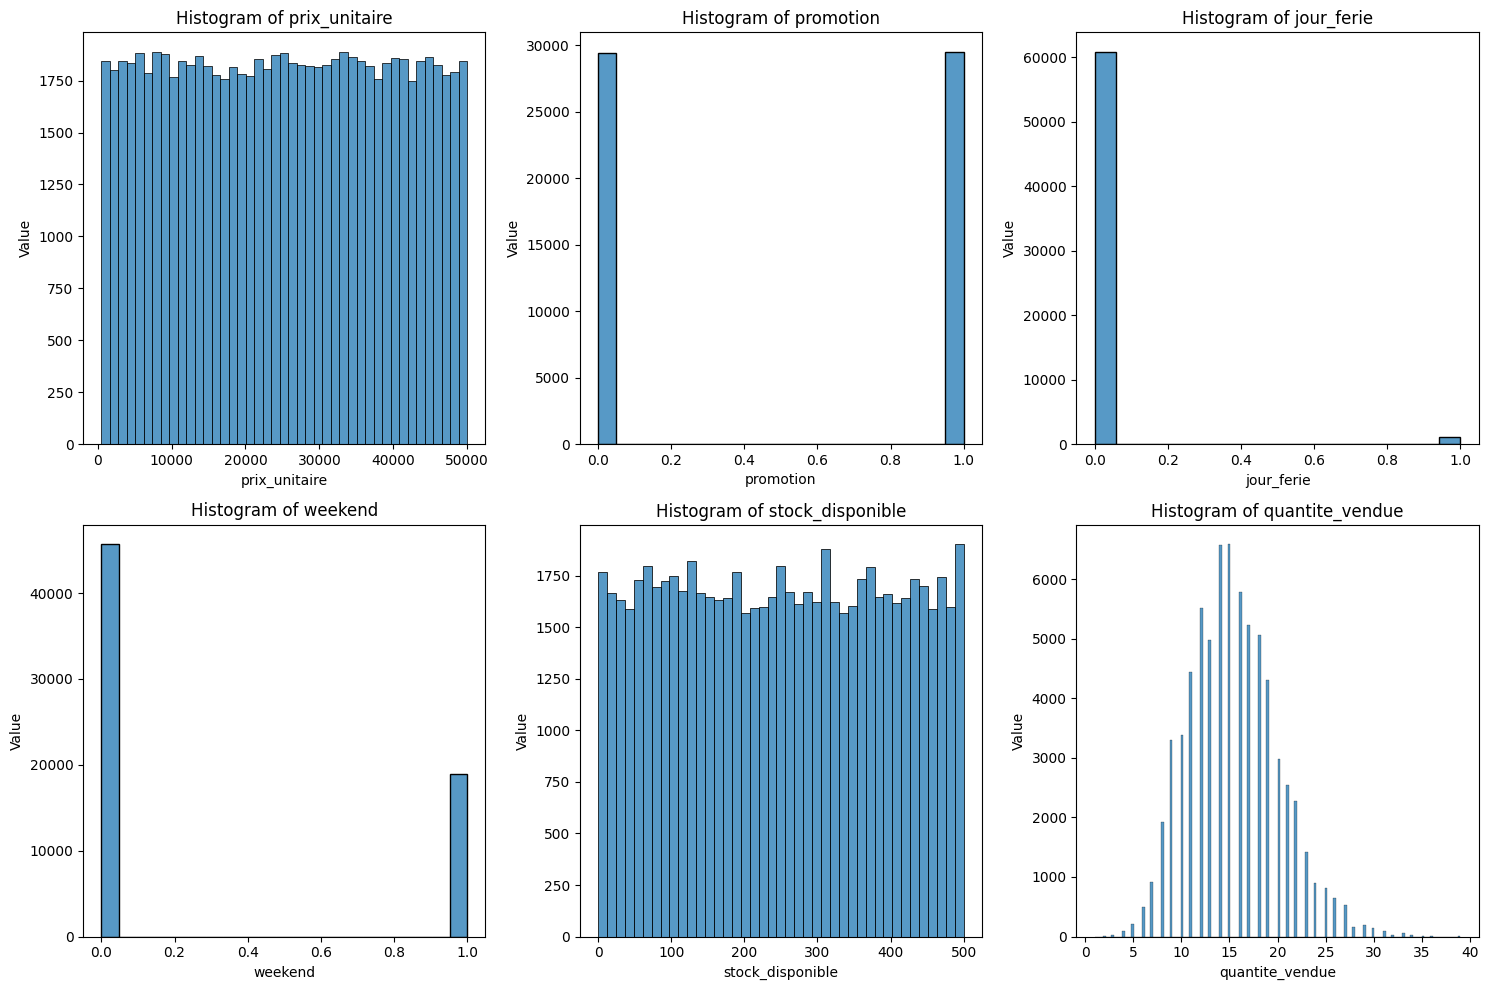

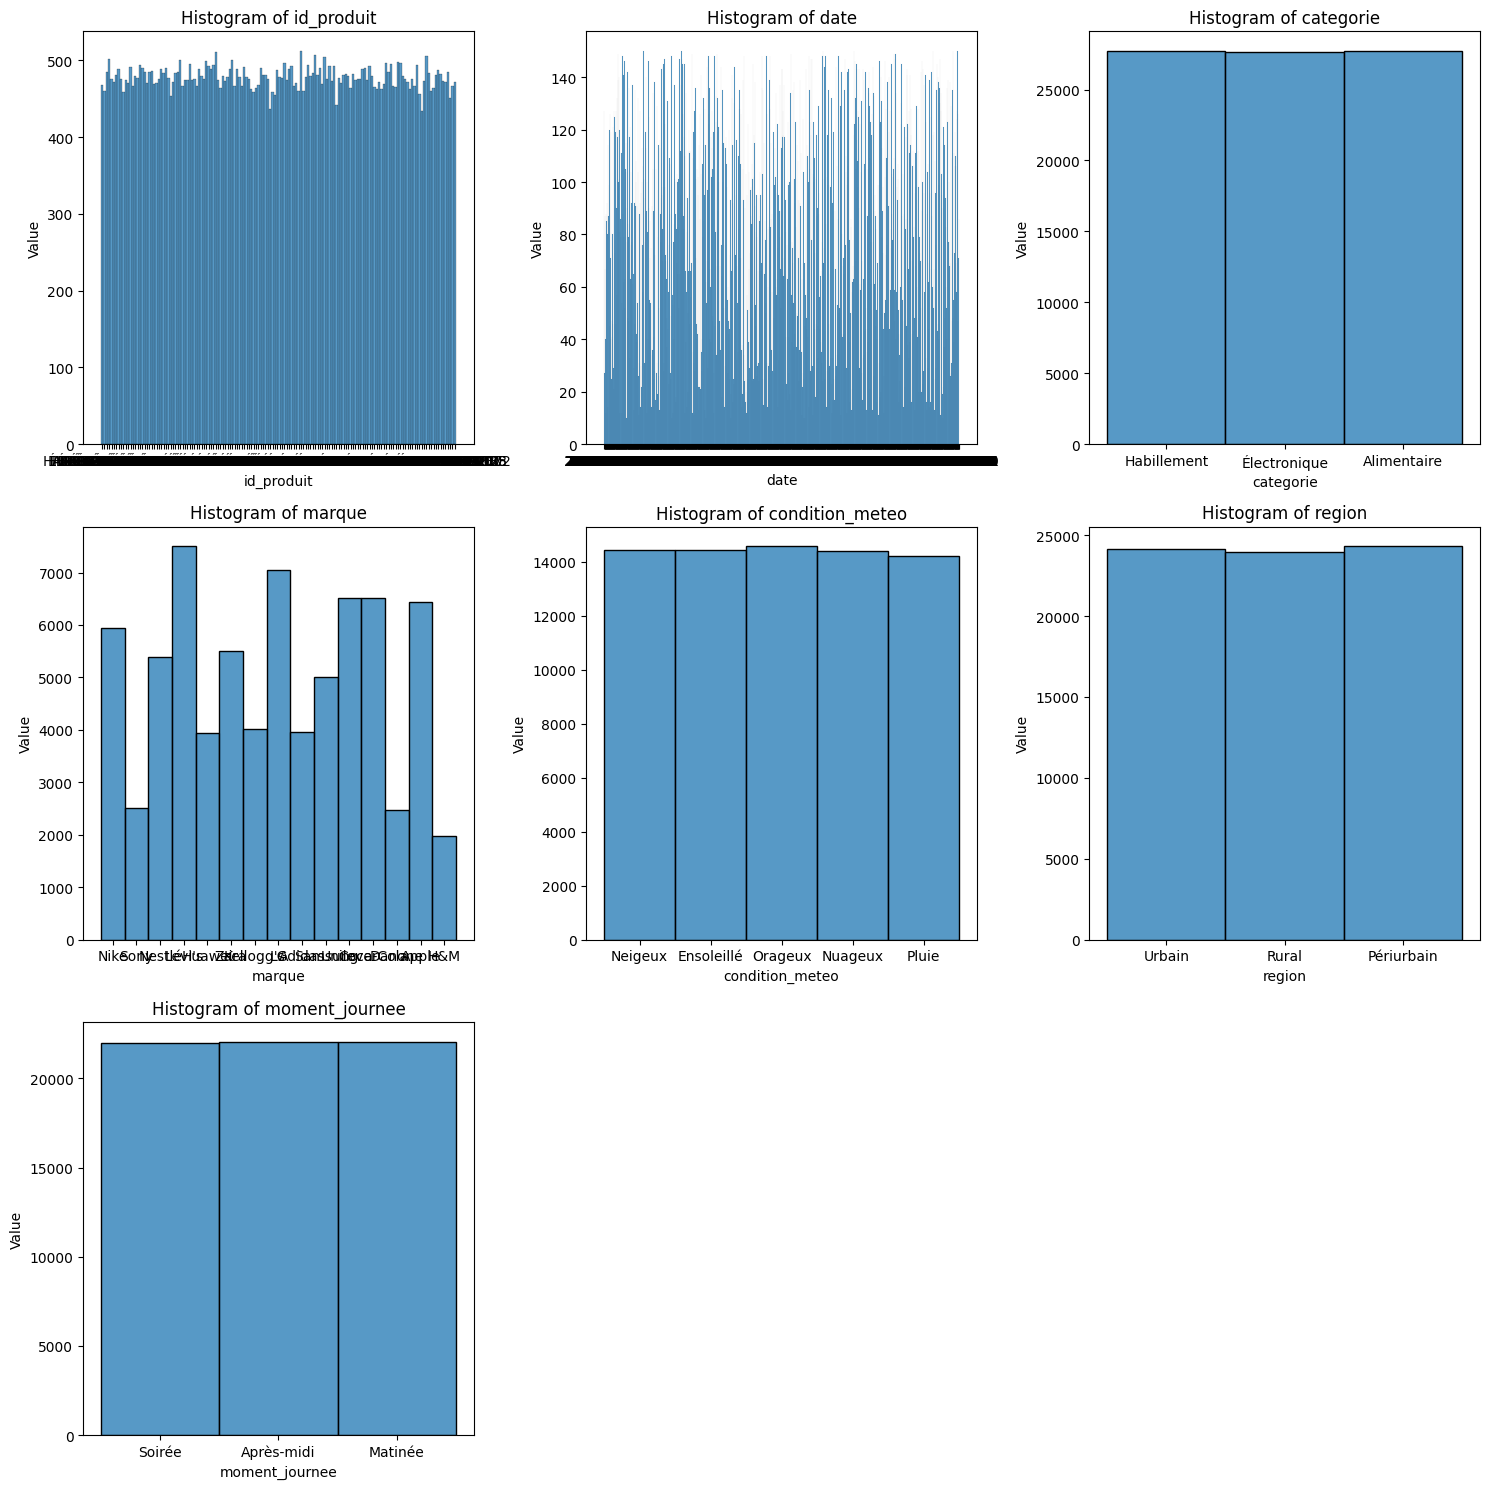

In [ ]:
show_hist_plots(trainV1, num_columns)
show_hist_plots(trainV1, cat_columns)

In [ ]:
print(nulls_summary_table(trainV1))
# print("==" *23)
# print(trainV1.sort_values(by="id_produit", ascending=False)["id_produit"].head(15))
trainV1

                  null_count  null_percentage
id_produit             11377         0.136995
date                       0         0.000000
categorie                  0         0.000000
marque                  8343         0.100461
prix_unitaire           4465         0.053765
promotion              24124         0.290486
jour_ferie             21065         0.253652
weekend                18460         0.222284
stock_disponible       14048         0.169157
condition_meteo        11016         0.132648
region                 10665         0.128421
moment_journee         16936         0.203933
quantite_vendue        11407         0.137356


,id_produit,date,categorie,marque,prix_unitaire,promotion,jour_ferie,weekend,stock_disponible,condition_meteo,region,moment_journee,quantite_vendue
0,HAB-102024-024,2022-01-01,Habillement,Nike,31247.38,0.0,0.0,1.0,37.0,Neigeux,Urbain,Soirée,NaN
1,ÉLE-062022-019,2022-01-01,Électronique,Sony,13627.42,1.0,0.0,1.0,NaN,Ensoleillé,Urbain,Après-midi,23.0
2,ALI-072022-019,2022-01-01,Alimentaire,Nestlé,14606.88,1.0,0.0,1.0,426.0,Neigeux,Rural,Après-midi,7.0
3,HAB-042023-029,2022-01-01,Habillement,Levi's,30778.05,0.0,0.0,NaN,341.0,Neigeux,Périurbain,Soirée,17.0
4,HAB-122023-027,2022-01-01,Habillement,NaN,5627.53,0.0,0.0,1.0,135.0,Ensoleillé,Urbain,Soirée,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83042,ALI-052023-045,2024-10-31,Alimentaire,NaN,26676.76,1.0,0.0,NaN,427.0,Pluie,Rural,Après-midi,12.0
83043,HAB-052022-049,2024-10-31,Habillement,Levi's,27778.70,0.0,NaN,0.0,0.0,NaN,Urbain,NaN,17.0
83044,HAB-012023-037,2024-10-31,Habillement,Zara,19270.58,1.0,NaN,0.0,245.0,Orageux,Urbain,Soirée,17.0
83045,HAB-092024-005,2024-10-31,Habillement,NaN,29740.40,1.0,NaN,0.0,139.0,Orageux,Urbain,Soirée,17.0


Encoding

In [ ]:
def option1(df):
  option1_df = df.copy()
  option1_df = mean_median_mode_imputation(option1_df, ["prix_unitaire", "stock_disponible"], option="mean")
  if "quantite_vendue" in option1_df.columns:
      option1_df = mean_median_mode_imputation(option1_df, ["quantite_vendue"], option="mean")

  option1_df = fill_weekend(option1_df) #weekend imputation
  option1_df = impute_jour_ferie(option1_df) #jour_ferie imputation
  # option1_df = mean_median_mode_imputation(option1_df, ["marque"], option="mode")
  option1_df = impute_promotion(option1_df) #promotion imputation
  # option1_df = mean_median_mode_imputation(option1_df, ["region"], option="mode")
  # option1_df = mean_median_mode_imputation(option1_df, ["moment_journee"], option="mode")
  option1_df = impute_moment_journee(option1_df) #moment_journee imputation
  option1_df = impute_meteo(option1_df) #meteo imputation
  option1_df = mean_median_mode_imputation(option1_df, ["condition_meteo"], option="mode") #meteo imputation of whats left
  # option1_df = ML_impute(option1_df[["id_produit", "categorie", "marque", "prix_unitaire"]], "random_forest")

  option1_df = drop_null_values_columns(option1_df, ["id_produit", "marque"])
  option1_df = encode_id_produit(option1_df)
  option1_df = one_hot_encode(option1_df, ["categorie", "condition_meteo"])
  option1_df = label_encode(option1_df, ["marque"])
  option1_df = drop_columns(option1_df, ["region", "moment_journee"])
  option1_df["date"] = pd.to_datetime(option1_df["date"])
  option1_df["year"] = option1_df["date"].dt.year
  option1_df["month"] = option1_df["date"].dt.month
  option1_df["day"] = option1_df["date"].dt.day
  option1_df["day_of_week"] = option1_df["date"].dt.dayofweek
  option1_df["day_of_year"] = option1_df["date"].dt.dayofyear
  option1_df["week_of_year"] = option1_df["date"].dt.weekday
  option1_df["quarter"] = option1_df["date"].dt.quarter
  option1_df = drop_columns(option1_df, ["date"])

  print(nulls_summary_table(option1_df))

  return option1_df

def option2(df):
  option2_df = df.copy()



In [ ]:
option1_df = option1(trainV1)
option1_df

X_train, X_test, y_train, y_test = train_test_split(option1_df.drop(columns=["quantite_vendue"]), option1_df["quantite_vendue"], test_size=0.2, random_state=42)
X_train

                            null_count  null_percentage
id_produit                           0              0.0
marque                               0              0.0
prix_unitaire                        0              0.0
promotion                            0              0.0
jour_ferie                           0              0.0
weekend                              0              0.0
stock_disponible                     0              0.0
quantite_vendue                      0              0.0
categorie_Alimentaire                0              0.0
categorie_Habillement                0              0.0
categorie_Électronique               0              0.0
condition_meteo_Ensoleillé           0              0.0
condition_meteo_Neigeux              0              0.0
condition_meteo_Nuageux              0              0.0
condition_meteo_Orageux              0              0.0
condition_meteo_Pluie                0              0.0
year                                 0          

,id_produit,marque,prix_unitaire,promotion,jour_ferie,weekend,stock_disponible,categorie_Alimentaire,categorie_Habillement,categorie_Électronique,...,condition_meteo_Nuageux,condition_meteo_Orageux,condition_meteo_Pluie,year,month,day,day_of_week,day_of_year,week_of_year,quarter
58894,2102022017,1,46796.76,1.0,0.0,0.0,55.0,False,False,True,...,True,False,False,2024,1,16,1,16,1,1
55123,32022042,6,41276.26,1.0,0.0,0.0,149.0,True,False,False,...,False,False,False,2023,12,6,2,340,2,4
79814,2092023046,1,30498.11,0.0,0.0,0.0,239.0,False,False,True,...,False,True,False,2024,9,26,3,270,3,3
8477,1012024010,8,3382.86,0.0,0.0,0.0,250.0,False,True,False,...,False,False,False,2022,4,15,4,105,4,2
68267,2112022034,5,569.30,1.0,0.0,0.0,250.0,False,False,True,...,False,False,False,2024,5,6,0,127,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80578,2062023040,7,32800.39,0.0,0.0,0.0,250.0,False,False,True,...,True,False,False,2024,10,4,4,278,4,4
49168,2062022019,12,29169.61,1.0,0.0,0.0,323.0,False,False,True,...,True,False,False,2023,9,14,3,257,3,3
1110,2032023031,11,41668.63,0.0,0.0,1.0,210.0,False,False,True,...,False,False,False,2022,1,16,6,16,6,1
20368,22024040,9,4841.72,0.0,0.0,0.0,250.0,True,False,False,...,False,False,False,2022,9,9,4,252,4,3


Training model: XGBRegressor
 regular ===> MAPE: 0.2493
 round ===> MAPE: 0.2482
 floor ===> MAPE: 0.2427
 ceil ===> MAPE: 0.2584


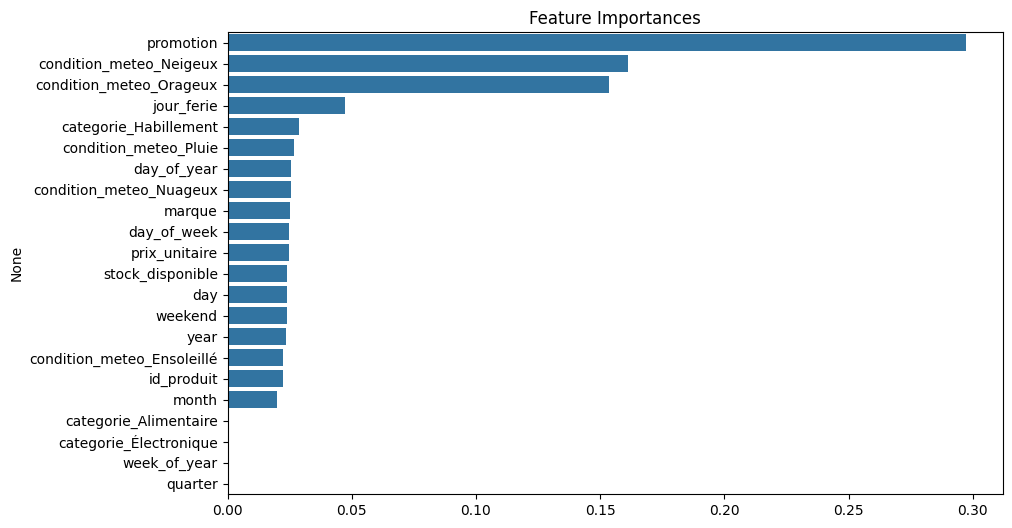

In [ ]:
print(f"Training model: XGBRegressor")
model = XGBRegressor()
model.fit(X_train, y_train)  # Train model
y_pred = model.predict(X_test)  # Make predictions

# Round, floor, and ceil predictions
y_pred_round = np.round(y_pred).astype(int)
y_pred_floor = np.floor(y_pred).astype(int)
y_pred_ceil = np.ceil(y_pred).astype(int)

# Compute MAPE scores
mape = mean_absolute_percentage_error(y_test, y_pred)
mape_round = mean_absolute_percentage_error(y_test, y_pred_round)
mape_floor = mean_absolute_percentage_error(y_test, y_pred_floor)
mape_ceil = mean_absolute_percentage_error(y_test, y_pred_ceil)

# Print results
print(f" regular ===> MAPE: {mape:.4f}")
print(f" round ===> MAPE: {mape_round:.4f}")
print(f" floor ===> MAPE: {mape_floor:.4f}")
print(f" ceil ===> MAPE: {mape_ceil:.4f}")
print("==" * 18)

# Plot Feature Importances
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]  # Sort indices in descending order

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices], y=X_train.columns[sorted_indices])
plt.title("Feature Importances")
plt.show()

modeling

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Elastic Net": ElasticNet(),
    "Bayesian Ridge": BayesianRidge(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "LightGBM Regressor": LGBMRegressor(),
    "CatBoost Regressor": CatBoostRegressor(verbose=0),
}

# Loop through models and train each
for model_name, model in models.items():
    print(f"\nTraining model: {model_name}")
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Make predictions

    y_pred_round = np.round(y_pred).astype(int)
    y_pred_floor = np.floor(y_pred).astype(int)
    y_pred_ceil = np.ceil(y_pred).astype(int)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mape_round = mean_absolute_percentage_error(y_test, y_pred_round)
    mape_floor = mean_absolute_percentage_error(y_test, y_pred_floor)
    mape_ceil = mean_absolute_percentage_error(y_test, y_pred_ceil)
    print(f" regular ===> MAPE: {mape:.4f}")
    print(f" round ===> MAPE: {mape_round:.4f}")
    print(f" floor ===> MAPE: {mape_floor:.4f}")
    print(f" ceil ===> MAPE: {mape_ceil:.4f}")
    print("==" * 18)



Training model: Linear Regression
 regular ===> MAPE: 0.2372
 round ===> MAPE: 0.2377
 floor ===> MAPE: 0.2408
 ceil ===> MAPE: 0.2333

Training model: Elastic Net
 regular ===> MAPE: 0.2489
 round ===> MAPE: 0.2435
 floor ===> MAPE: 0.2435
 ceil ===> MAPE: 0.2543

Training model: Bayesian Ridge
 regular ===> MAPE: 0.2372
 round ===> MAPE: 0.2376
 floor ===> MAPE: 0.2408
 ceil ===> MAPE: 0.2333

Training model: Gradient Boosting
 regular ===> MAPE: 0.2401
 round ===> MAPE: 0.2394
 floor ===> MAPE: 0.2399
 ceil ===> MAPE: 0.2433

Training model: Hist Gradient Boosting
 regular ===> MAPE: 0.2403
 round ===> MAPE: 0.2395
 floor ===> MAPE: 0.2402
 ceil ===> MAPE: 0.2431

Training model: AdaBoost
 regular ===> MAPE: 0.2433
 round ===> MAPE: 0.2440
 floor ===> MAPE: 0.2394
 ceil ===> MAPE: 0.2459

Training model: XGBoost Regressor
 regular ===> MAPE: 0.2465
 round ===> MAPE: 0.2457
 floor ===> MAPE: 0.2464
 ceil ===> MAPE: 0.2491

Training model: LightGBM Regressor
[LightGBM] [Info] Auto-ch

In [ ]:
models = {
    "Elastic Net": ElasticNet(),
    "Bayesian Ridge": BayesianRidge(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "LightGBM Regressor": LGBMRegressor(verbose=-1),
    "CatBoost Regressor": CatBoostRegressor(verbose=0),
    "Random Forest": RandomForestRegressor()
}

print("================ scaled features ================")
# Loop through models and train each
for model_name, model in models.items():
    print(f"\nTraining model: {model_name}")
    model.fit(X_train, y_train)  # Train model
    y_pred = np.ceil(model.predict(X_test))  # Make predictions
    mape = mean_absolute_percentage_error(y_test, y_pred)  # Calculate MAPE
    print(f"{model_name} ===> MAPE: {mape:.4f}")  # Print the performance of the model
    print("==" * 18)


================ scaled features ================

Training model: Elastic Net
Elastic Net ===> MAPE: 0.2543

Training model: Bayesian Ridge
Bayesian Ridge ===> MAPE: 0.2333

Training model: Gradient Boosting
Gradient Boosting ===> MAPE: 0.2433

Training model: Hist Gradient Boosting
Hist Gradient Boosting ===> MAPE: 0.2432

Training model: AdaBoost
AdaBoost ===> MAPE: 0.2491

Training model: XGBoost Regressor
XGBoost Regressor ===> MAPE: 0.2491

Training model: LightGBM Regressor
LightGBM Regressor ===> MAPE: 0.2434

Training model: CatBoost Regressor
CatBoost Regressor ===> MAPE: 0.2448

Training model: Random Forest
Random Forest ===> MAPE: 0.2472


### Hyperparams tuning

**Models**

In [ ]:
models_params = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },

    "Lasso": {
        "model": Lasso(),
        "params": {
            'alpha': np.logspace(-4, 0, 50),
            'max_iter': [500, 1000, 2000],
            'tol': [1e-4, 1e-3, 1e-2]
        }
    },

    "LightGBM Regressor": {
        "model": LGBMRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [-1, 5, 10],
            "num_leaves": [31, 50, 100],
            "subsample": [0.8, 1.0],
            "verbose":[-1],
            "colsample_bytree": [0.8, 1.0],
            "random_state": [42]
        }
    },

    "Gradient Boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "min_samples_split": [2, 5, 10],
            "subsample": [0.8, 1.0],
            "random_state": [42]
        }
    },

    "AdaBoost": {
        "model": AdaBoostRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0],
            "loss": ["linear", "square", "exponential"],
            "random_state": [42]
        }
    },

    "XGBoost Regressor": {
        "model": XGBRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "alpha": [0, 1, 10],
            "lambda": [0, 1, 10],
            "random_state": [42]
        }
    },

    "CatBoost Regressor": {
        "model": CatBoostRegressor(verbose=0),
        "params": {
            "iterations": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "depth": [3, 5, 7],
            "l2_leaf_reg": [1, 3, 5],
            "subsample": [0.8, 1.0],
            "random_state": [42]
        }
    },

    "Extra Trees": {
        "model": ExtraTreesRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 5, 10, 20, 50],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
            "max_features": ["sqrt", "log2"],
            "bootstrap": [True, False],
            "random_state": [42]
        }
    },

    "Hist Gradient Boosting": {
        "model": HistGradientBoostingRegressor(),
        "params": {
            "learning_rate": [0.01, 0.1, 0.2],
            "max_iter": [50, 100, 200],
            "max_depth": [3, 5, 7],
            "min_samples_leaf": [1, 2, 5],
            "max_bins": [255, 511],
            "random_state": [42]
        }
    },
      "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [50, 100, 200, 500],
            "max_depth": [None, 5, 10, 20, 50],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
            "max_features": ["sqrt", "log2"],
            "bootstrap": [True, False],
            "random_state": [42]
        }
      }
}


In [ ]:
# Define MAPE function
def mape_function(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Loop through each model in models_params
for model_name, params in models_params.items():
    model = params["model"]
    param_dist = params["params"]

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,  # Number of random combinations to try
        cv=5,
        scoring='neg_mean_absolute_percentage_error',  # Scoring with MAPE
        verbose=0,  # Print progress (set to 1 or 2 for more detail)
        random_state=42
    )

    # Train the model with the training fold data
    random_search.fit(X_train, y_train)

    # Get the best model from the search
    best_model = random_search.best_estimator_

    # Predict on the test fold
    y_pred = best_model.predict(X_test)
    y_pred_round = np.round(y_pred).astype(int)
    y_pred_floor = np.floor(y_pred).astype(int)
    y_pred_ceil = np.ceil(y_pred).astype(int)

    # Calculate MAPE for this fold and store it
    mape_score = mape_function(y_test, y_pred)

    # Print MAPE for this fold
    print(f"{model_name} =====>  regular MAPE: {mape_score:.4f}")
    print(f"{model_name} =====>  round MAPE: {mape_function(y_test, y_pred_round):.4f}")
    print(f"{model_name} =====>  floor MAPE: {mape_function(y_test, y_pred_floor):.4f}")
    print(f"{model_name} =====>  ceil MAPE: {mape_function(y_test, y_pred_ceil):.4f}")

    print(f"{model_name} Best params :{random_search.best_params_}")
    print("="*66)


Linear Regression =====>  regular MAPE: 0.2372
Linear Regression =====>  round MAPE: 0.2377
Linear Regression =====>  floor MAPE: 0.2408
Linear Regression =====>  ceil MAPE: 0.2333
Linear Regression Best params :{}
Lasso =====>  regular MAPE: 0.2365
Lasso =====>  round MAPE: 0.2360
Lasso =====>  floor MAPE: 0.2388
Lasso =====>  ceil MAPE: 0.2334
Lasso Best params :{'tol': 0.0001, 'max_iter': 500, 'alpha': 0.04941713361323833}
LightGBM Regressor =====>  regular MAPE: 0.2404
LightGBM Regressor =====>  round MAPE: 0.2393
LightGBM Regressor =====>  floor MAPE: 0.2395
LightGBM Regressor =====>  ceil MAPE: 0.2441
LightGBM Regressor Best params :{'verbose': -1, 'subsample': 0.8, 'random_state': 42, 'num_leaves': 100, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


In [ ]:
Lasso = {'tol': 0.0001, 'max_iter': 500, 'alpha': 0.04941713361323833}
LightGBM = {'verbose': -1, 'subsample': 0.8, 'random_state': 42, 'num_leaves': 100, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
LightGBM = {'verbose': -1, 'subsample': 0.8, 'random_state': 42, 'num_leaves': 100, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Gradient_Boosting = {'subsample': 1.0, 'random_state': 42, 'n_estimators': 200, 'min_samples_split': 2, 'learning_rate': 0.01}
AdaBoost = {'random_state': 42, 'n_estimators': 50, 'loss': 'linear', 'learning_rate': 0.01}
XGBoost = {'subsample': 0.8, 'random_state': 42, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'lambda': 10, 'colsample_bytree': 1.0, 'alpha': 0}
CatBoost = {'subsample': 0.8, 'random_state': 42, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 200, 'depth': 7}
{'subsample': 0.8, 'random_state': 42, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 200, 'depth': 7}
Extra_Trees = {'random_state': 42, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}
Hist_Gradient_Boosting = {'random_state': 42, 'min_samples_leaf': 2, 'max_iter': 50, 'max_depth': 3, 'max_bins': 255, 'learning_rate': 0.1}
Random_Forest = {'random_state': 42, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}

In [ ]:
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # for HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

models_best_params = {
    "XGBoost": {
        "model": xgb.XGBRegressor(enable_categorical=True),
        "params": {
            "subsample": 0.8,
            "random_state": 42,
            "n_estimators": 200,
            "max_depth": 5,
            "learning_rate": 0.01,
            "reg_lambda": 10,
            "colsample_bytree": 1.0,
            "alpha": 0,
            "enable_categorical": True
        }
    },

    "CatBoost": {
        "model": CatBoostRegressor(verbose=0, cat_features=['jour_ferie', 'weekend', 'month']),  # `silent=True` to suppress warnings
        "params": {
            "subsample": 0.8,
            "random_state": 42,
            "learning_rate": 0.01,
            "l2_leaf_reg": 1,
            "iterations": 200,
            "depth": 7
        }
    },

    "Lasso": {
        "model": Lasso(),
        "params": {
            "tol": 0.0001,
            "max_iter": 500,
            "alpha": 0.04941713361323833
        }
    },
    "LightGBM": {
        "model": LGBMRegressor(),
        "params": {
            "verbose": -1,
            "subsample": 0.8,
            "random_state": 42,
            "num_leaves": 100,
            "n_estimators": 200,
            "max_depth": 5,
            "learning_rate": 0.01,
            "colsample_bytree": 1.0
        }
    },
    "Gradient_Boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "subsample": 1.0,
            "random_state": 42,
            "n_estimators": 200,
            "min_samples_split": 2,
            "learning_rate": 0.01
        }
    },
    "AdaBoost": {
        "model": AdaBoostRegressor(),
        "params": {
            "random_state": 42,
            "n_estimators": 50,
            "loss": "linear",
            "learning_rate": 0.01
        }
    },

    "Extra_Trees": {
        "model": ExtraTreesRegressor(),
        "params": {
            "random_state": 42,
            "n_estimators": 50,
            "min_samples_split": 2,
            "min_samples_leaf": 5,
            "max_features": "sqrt",
            "max_depth": 5,
            "bootstrap": False
        }
    },
    "Hist_Gradient_Boosting": {
        "model": HistGradientBoostingRegressor(),
        "params": {
            "random_state": 42,
            "min_samples_leaf": 2,
            "max_iter": 50,
            "max_depth": 3,
            "max_bins": 255,
            "learning_rate": 0.1
        }
    },
    "Random_Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "random_state": 42,
            "n_estimators": 100,
            "min_samples_split": 10,
            "min_samples_leaf": 2,
            "max_features": "sqrt",
            "max_depth": 5,
            "bootstrap": False
        }
    }
}


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each model in models_best_params
for model_name, params in models_best_params.items():
  model = params["model"]
  param_dict = params["params"]

  model.set_params(**param_dict)


  fold_scores = []  # Initialize this for each model
  print(f"========== Starting cross-validation for {model_name} ==========")

  # Perform cross-validation
  for i, (train_index, test_index) in enumerate(kf.split(X_train)):
      X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
      y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

      # Set the best parameters directly

      # Train the model with the training fold data
      best_model = model.fit(X_train_fold, y_train_fold)

      # Predict on the test fold
      y_pred = best_model.predict(X_test_fold)

      # Calculate MAPE for this fold and store it
      fold_mape = mape_function(y_test_fold, y_pred)
      fold_scores.append(fold_mape)

      # Print MAPE for this fold
      print(f"Fold [{i}] =====> MAPE: {fold_mape}")

  # Calculate the mean MAPE for this model across all folds
  mean_fold_mape = np.mean(fold_scores)
  print(f"{model_name} - Mean MAPE across folds: {mean_fold_mape}")

  # After cross-validation, retrain the best model on the full training data
  best_model = model.fit(X_train, y_train)  # Retrain on the entire training set

  # Get predictions from the model on the test or validation set
  y_pred_final = best_model.predict(X_test)  # or X_valid if using a validation set

  # Calculate and print the final MAPE on the test/validation set
  final_mape = mape_function(y_test, y_pred_final)  # or y_valid if using a validation set
  print(f"{model_name} - Final MAPE on the test set: {final_mape}")
  print("="*66)


In [ ]:
from sklearn.ensemble import VotingRegressor

# Create the individual models
models = [
    ('Lasso', Lasso(tol=0.0001, max_iter=500, alpha=0.04941713361323833)),
    ('LightGBM', LGBMRegressor(
        verbose=-1, subsample=0.8, random_state=42, num_leaves=100,
        n_estimators=200, max_depth=5, learning_rate=0.01, colsample_bytree=1.0)),
    ('GradientBoosting', GradientBoostingRegressor(
        subsample=1.0, random_state=42, n_estimators=200, min_samples_split=2, learning_rate=0.01)),
    ('AdaBoost', AdaBoostRegressor(
        random_state=42, n_estimators=50, loss="linear", learning_rate=0.01)),
    ('XGBoost', xgb.XGBRegressor(
        subsample=0.8, random_state=42, n_estimators=200, max_depth=5, learning_rate=0.01,
        reg_lambda=10, colsample_bytree=1.0, alpha=0)),
    ('CatBoost', CatBoostRegressor(
        subsample=0.8, random_state=42, learning_rate=0.01, l2_leaf_reg=1, iterations=200, depth=7, silent=True))
]

# Create the Voting Regressor
voting_regressor = VotingRegressor(estimators=models)

# Fit the voting model
voting_regressor.fit(X_train, y_train)

# Predict and evaluate
voting_preds = voting_regressor.predict(X_test)
voting_mape = mape_function(y_test, voting_preds)
print(f"Voting Regressor MAPE: {voting_mape}")


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Define the base models
base_models = [
    ('Lasso', Lasso(tol=0.0001, max_iter=500, alpha=0.04941713361323833)),
    ('LightGBM', LGBMRegressor(
        verbose=-1, subsample=0.8, random_state=42, num_leaves=100,
        n_estimators=200, max_depth=5, learning_rate=0.01, colsample_bytree=1.0)),
    ('GradientBoosting', GradientBoostingRegressor(
        subsample=1.0, random_state=42, n_estimators=200, min_samples_split=2, learning_rate=0.01)),
    ('AdaBoost', AdaBoostRegressor(
        random_state=42, n_estimators=50, loss="linear", learning_rate=0.01)),
    ('XGBoost', xgb.XGBRegressor(
        subsample=0.8, random_state=42, n_estimators=200, max_depth=5, learning_rate=0.01,
        reg_lambda=10, colsample_bytree=1.0, alpha=0)),
    ('CatBoost', CatBoostRegressor(
        subsample=0.8, random_state=42, learning_rate=0.01, l2_leaf_reg=1, iterations=200, depth=7, silent=True))
]

# Define the meta-model (Linear Regression)
meta_model = LinearRegression()

# Create Stacking Regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Fit the stacking model
stacking_regressor.fit(X_train, y_train)

# Predict and evaluate
stacking_preds = stacking_regressor.predict(X_test)
stacking_mape = mape_function(y_test, stacking_preds)
print(f"Stacking Regressor MAPE: {stacking_mape}")


**Test submission**

In [ ]:
subV1 = sub.copy()
num_columns = get_num_cat_columns(subV1)["numerical"].tolist()
cat_columns = get_num_cat_columns(subV1)["categorical"].tolist()
print(nulls_summary_table(subV1))
print("\n")
for column in num_columns:
  extract_outliers(subV1[column])

In [ ]:
show_hist_plots(subV1, num_columns)
show_hist_plots(subV1, cat_columns)

In [ ]:
option1_sub_df = option1(subV1)
option1_sub_df

**creating the submission ====> using {voting_regressor}**

In [ ]:
y_sub = voting_regressor.predict(option1_sub_df)
y_sub
y_sub_df = pd.DataFrame({
    "id": range(1, len(y_sub) + 1),
    "quantite_vendue": y_sub
})

y_sub_df.to_csv("subV3.csv", index=False)

## 2

In [ ]:
print(nulls_summary_table(trainV1))

                  null_count  null_percentage
id_produit             11377         0.136995
date                       0         0.000000
categorie                  0         0.000000
marque                  8343         0.100461
prix_unitaire           4465         0.053765
promotion              24124         0.290486
jour_ferie             21065         0.253652
weekend                18460         0.222284
stock_disponible       14048         0.169157
condition_meteo        11016         0.132648
region                 10665         0.128421
moment_journee         16936         0.203933
quantite_vendue        11407         0.137356


In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Separate rows with and without missing target values
train_with_target = train[train['quantite_vendue'].notna()]  # Rows with no missing target
train_missing_target = train[train['quantite_vendue'].isna()]  # Rows with missing target

# Step 2: Split the data with no missing target into training and test sets
X = train_with_target.drop(['quantite_vendue'], axis=1)  # Exclude the target variable
y = train_with_target['quantite_vendue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

# Step 3: Add rows with missing target back to the training set
X_train_final = pd.concat([X_train, train_missing_target.drop(['quantite_vendue'], axis=1)])
y_train_final = pd.concat([y_train, train_missing_target['quantite_vendue']])

X_test_final = X_test.copy()
y_test_final = y_test.copy()
# Print shapes to verify
print(f"Training data shape: X_train={X_train_final.shape}, y_train={y_train_final.shape}")
print(f"Test data shape: X_test={X_test_final.shape}, y_test={y_test_final.shape}")
tr = pd.concat([X_train_final, y_train_final], axis=1)
te = pd.concat([X_test_final, y_test_final], axis=1)

trainV1 = pd.concat([tr, te], ignore_index=True)

option2_df = trainV1.copy()
option2_df = fill_weekend(option2_df)

option2_df = drop_columns(option2_df, ["condition_meteo","region", "moment_journee"])
option2_df = drop_null_values_columns(option2_df, ["marque", "id_produit"])

option2_df["date"] = pd.to_datetime(option2_df["date"])
option2_df["month"] = option2_df["date"].dt.month
option2_df["day"] = option2_df["date"].dt.day
option2_df["quarter"] = option2_df["date"].dt.quarter
option2_df = drop_columns(option2_df, ["date"])
option2_df = impute_catrgories_ml(option2_df, "jour_ferie", ["weekend", "month"])
option2_df = impute_catrgories_ml(option2_df, "promotion", ["weekend", "month", "jour_ferie"])
# option2_df = impute_nums_ml(option2_df, "prix_unitaire", ["jour_ferie", "promotion", "weekend"])
option2_df = impute_column_randomly(option2_df, "prix_unitaire")
option2_df = impute_nums_ml(option2_df, "quantite_vendue", ["jour_ferie", "promotion", "weekend"])
# option2_df = impute_nums_ml(option2_df, "stock_disponible", ["jour_ferie", "promotion", "weekend", "prix_unitaire"])
option2_df = impute_column_randomly(option2_df, "stock_disponible")

'''=============== encoding =============='''

# option2_df = target_encode(option2_df, "id_produit", "quantite_vendue")
# option2_df = target_encode(option2_df, "marque", "quantite_vendue")
option2_df = label_encode(option2_df, ["id_produit"])
option2_df = label_encode(option2_df, ["marque"])
option2_df, _ = one_hot_encode(option2_df, ["categorie"])
option2_df
print(nulls_summary_table(option2_df))
X_train, X_test = option2_df.drop("quantite_vendue", axis=1).iloc[:len(y_train)], option2_df.drop("quantite_vendue", axis=1).iloc[len(y_train):]
y_train, y_test = option2_df["quantite_vendue"].iloc[:len(y_train)], option2_df["quantite_vendue"].iloc[len(y_train):]
option2_df
print(np.any(np.isnan(y_train)))  # Check for NaN
print(np.any(np.isinf(y_train)))  # Check for infinity

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test data shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training data shape: X_train=(65137, 12), y_train=(65137,)
Test data shape: X_test=(17910, 12), y_test=(17910,)
0:	learn: 0.6836665	total: 3.36ms	remaining: 165ms
49:	learn: 0.3781281	total: 170ms	remaining: 0us
0:	learn: 0.6931557	total: 2.52ms	remaining: 124ms
49:	learn: 0.6930512	total: 191ms	remaining: 0us
number of predicted values 8923
Missing values in 'quantite_vendue' have been imputed using linear model.
                        null_count  null_percentage
id_produit                       0              0.0
marque                           0              0.0
prix_unitaire                    0              0.0
promotion                        0              0.0
jour_ferie                       0              0.0
weekend                          0              0.0
stock_disponible                 0              0.0
quantite_vendue                  0              0.0
month                            0              0.0
day                              0              0.0
quarter   

In [ ]:
option2_sub_df = sub.copy()
option2_sub_df = fill_weekend(option2_sub_df)

option2_sub_df = drop_columns(option2_sub_df, ["condition_meteo","region", "moment_journee"])

option2_sub_df["date"] = pd.to_datetime(option2_sub_df["date"])
option2_sub_df["month"] = option2_sub_df["date"].dt.month
option2_sub_df["day"] = option2_sub_df["date"].dt.day
option2_sub_df["quarter"] = option2_sub_df["date"].dt.quarter
option2_sub_df = drop_columns(option2_sub_df, ["date"])
option2_sub_df = impute_catrgories_ml(option2_sub_df, "promotion", ["weekend", "month", "jour_ferie"])
# option2_sub_df = impute_nums_ml(option2_sub_df, "prix_unitaire", ["jour_ferie", "promotion", "weekend"])
option2_sub_df = impute_column_randomly(option2_sub_df, "prix_unitaire")
# option2_sub_df = impute_nums_ml(option2_sub_df, "stock_disponible", ["jour_ferie", "promotion", "weekend", "prix_unitaire"])
option2_sub_df = impute_column_randomly(option2_sub_df, "stock_disponible")

'''=============== encoding =============='''

# option2_sub_df = target_encode(option2_sub_df, "id_produit", "quantite_vendue")
# option2_sub_df = target_encode(option2_sub_df, "marque", "quantite_vendue")
option2_sub_df = frequency_encoding(option2_sub_df, "id_produit")
option2_sub_df = frequency_encoding(option2_sub_df, "marque")
option2_sub_df = one_hot_encode(option2_sub_df, ["categorie"])
option2_sub_df
print(nulls_summary_table(option2_sub_df))
option2_sub_df["jour_ferie"].unique()

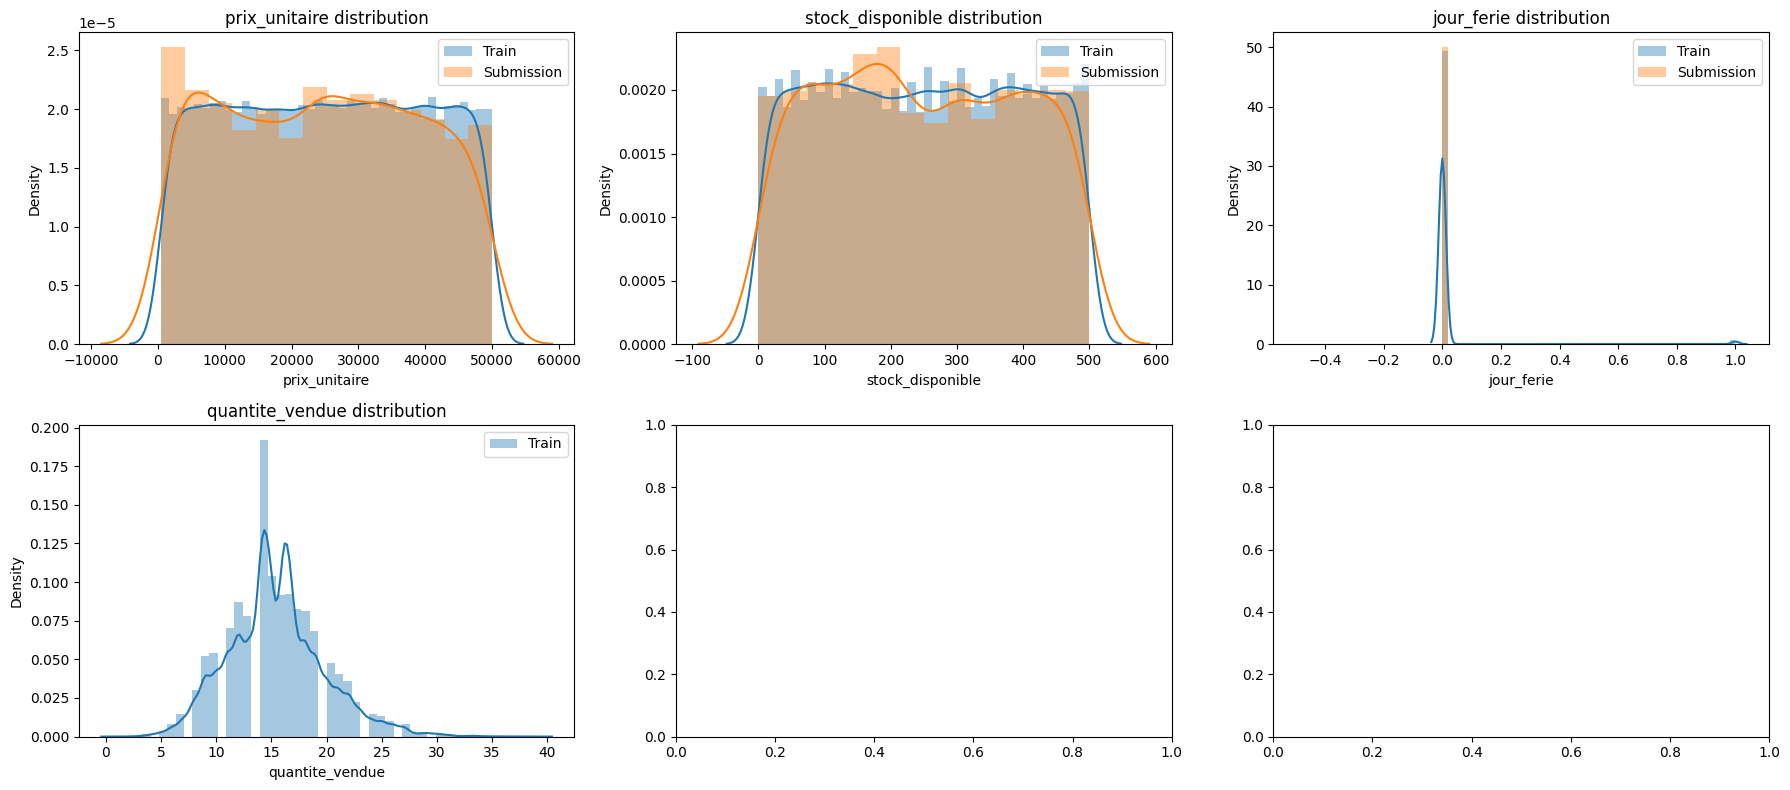

In [ ]:
plot_histograms(option2_df[["prix_unitaire", "stock_disponible", "jour_ferie", "quantite_vendue"]], option2_sub_df[["prix_unitaire", "stock_disponible", "jour_ferie"]], "quantite_vendue")

In [ ]:
option2_df.select_dtypes(include="object").columns

Index(['jour_ferie', 'weekend', 'month'], dtype='object')

Training model: XGBRegressor
 regular ===> MAPE: 0.2931
 round ===> MAPE: 0.2930
 floor ===> MAPE: 0.2815
 ceil ===> MAPE: 0.3059
 custom ===> MAPE: 0.2845


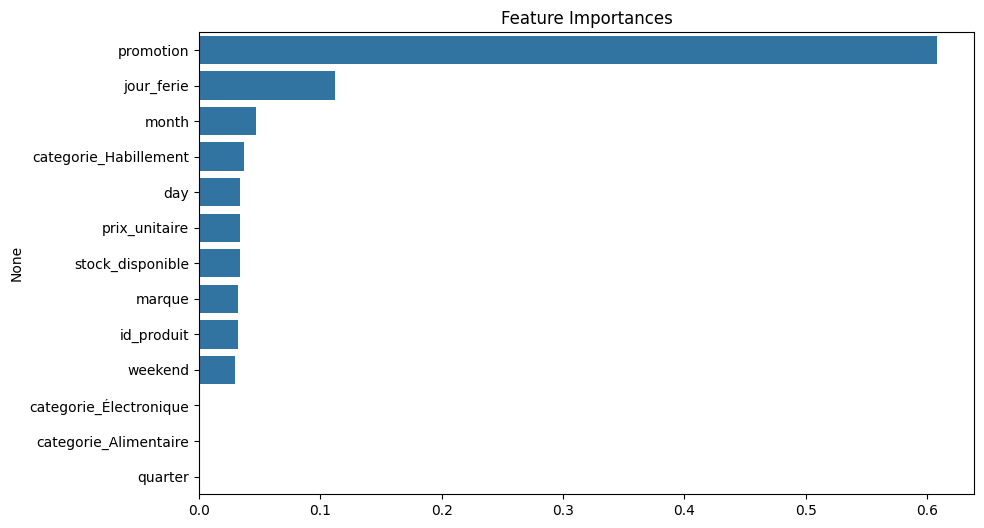

In [ ]:
# Convert all object columns to category
for col in X_train.select_dtypes(include="object").columns:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

print(f"Training model: XGBRegressor")
model = XGBRegressor(enable_categorical= True)
model.fit(X_train, y_train)  # Train model
y_pred = model.predict(X_test)  # Make predictions

# Round, floor, and ceil predictions
y_pred_round = np.round(y_pred).astype(int)
y_pred_floor = np.floor(y_pred).astype(int)
y_pred_ceil = np.ceil(y_pred).astype(int)
y_pred_custom = np.vectorize(lambda x: int(x) + 1 if x - int(x) >= 0.85 else int(x))

# Compute MAPE scores
mape = mean_absolute_percentage_error(y_test, y_pred)
mape_round = mean_absolute_percentage_error(y_test, y_pred_round)
mape_floor = mean_absolute_percentage_error(y_test, y_pred_floor)
mape_ceil = mean_absolute_percentage_error(y_test, y_pred_ceil)
round_custom = np.vectorize(lambda x: int(x) + 1 if x - int(x) >= 0.85 else int(x))
y_pred_custom = round_custom(y_pred)

mape_custom = mean_absolute_percentage_error(y_test, y_pred_custom)
# Print results
print(f" regular ===> MAPE: {mape:.4f}")
print(f" round ===> MAPE: {mape_round:.4f}")
print(f" floor ===> MAPE: {mape_floor:.4f}")
print(f" ceil ===> MAPE: {mape_ceil:.4f}")
print(f" custom ===> MAPE: {mape_custom:.4f}")
print("==" * 18)

# Plot Feature Importances
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]  # Sort indices in descending order

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices], y=X_train.columns[sorted_indices])
plt.title("Feature Importances")
plt.show()


In [ ]:
models_params = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },

    "Lasso": {
        "model": Lasso(),
        "params": {
            'alpha': np.logspace(-4, 0, 50),
            'max_iter': [500, 1000, 2000],
            'tol': [1e-4, 1e-3, 1e-2]
        }
    },

    "CatBoost Regressor": {
        "model": CatBoostRegressor(verbose=0, cat_features=['jour_ferie', 'weekend', 'month']),
        "params": {
            "iterations": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "depth": [3, 5, 7],
            "l2_leaf_reg": [1, 3, 5],
            "subsample": [0.8, 1.0],
            "random_state": [42]
        }
    },



    "XGBoost Regressor": {
        "model": XGBRegressor(enable_categorical=True),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "alpha": [0, 1, 10],
            "reg_lambda": [0, 1, 10],
            "random_state": [42]
        }
    },

    "LightGBM Regressor": {
        "model": LGBMRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [-1, 5, 10],
            "num_leaves": [31, 50, 100],
            "subsample": [0.8, 1.0],
            "verbose":[-1],
            "colsample_bytree": [0.8, 1.0],
            "random_state": [42]
        }
    },

    "Gradient Boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "min_samples_split": [2, 5, 10],
            "subsample": [0.8, 1.0],
            "random_state": [42]
        }
    },

    "AdaBoost": {
        "model": AdaBoostRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0],
            "loss": ["linear", "square", "exponential"],
            "random_state": [42]
        }
    },

    "Extra Trees": {
        "model": ExtraTreesRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 5, 10, 20, 50],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
            "max_features": ["sqrt", "log2"],
            "bootstrap": [True, False],
            "random_state": [42]
        }
    },

    "Hist Gradient Boosting": {
        "model": HistGradientBoostingRegressor(),
        "params": {
            "learning_rate": [0.01, 0.1, 0.2],
            "max_iter": [50, 100, 200],
            "max_depth": [3, 5, 7],
            "min_samples_leaf": [1, 2, 5],
            "max_bins": [255, 511],
            "random_state": [42]
        }
    },
      "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [50, 100, 200, 500],
            "max_depth": [None, 5, 10, 20, 50],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
            "max_features": ["sqrt", "log2"],
            "bootstrap": [True, False],
            "random_state": [42]
        }
      }
}


In [ ]:
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # for HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

models_best_params = {
    "XGBoost": {
        "model": xgb.XGBRegressor(enable_categorical=True),
        "params": {
            "subsample": 0.8,
            "random_state": 42,
            "n_estimators": 200,
            "max_depth": 3,
            "learning_rate": 0.1,
            "reg_lambda": 10,
            "colsample_bytree": 0.8,
            "alpha": 0,
            "enable_categorical": True

        }
    },

    "CatBoost": {
        "model": CatBoostRegressor(verbose=0, cat_features=['jour_ferie', 'weekend', 'month']),  # `silent=True` to suppress warnings
        "params": {
            "subsample": 0.8,
            "random_state": 42,
            "learning_rate": 0.01,
            "l2_leaf_reg": 1,
            "iterations": 200,
            "depth": 7
        }
    },

    "Lasso": {
        "model": Lasso(),
        "params": {
            "tol": 0.001,
            "max_iter": 1000,
            "alpha": 0.0024420530945486497
        }
    },
    "LightGBM": {
        "model": LGBMRegressor(),
        "params": {
            "verbose": -1,
            "subsample": 0.8,
            "random_state": 42,
            "num_leaves": 100,
            "n_estimators": 200,
            "max_depth": 5,
            "learning_rate": 0.01,
            "colsample_bytree": 1.0
        }
    },
    "Gradient_Boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "subsample": 1.0,
            "random_state": 42,
            "n_estimators": 200,
            "min_samples_split": 2,
            "learning_rate": 0.01
        }
    },
    "AdaBoost": {
        "model": AdaBoostRegressor(),
        "params": {
            "random_state": 42,
            "n_estimators": 50,
            "loss": "linear",
            "learning_rate": 0.01
        }
    },

    "Extra_Trees": {
        "model": ExtraTreesRegressor(),
        "params": {
            "random_state": 42,
            "n_estimators": 200,
            "min_samples_split": 5,
            "min_samples_leaf": 1,
            "max_features": "sqrt",
            "max_depth": 10,
            "bootstrap": False
        }
    },
    "Hist_Gradient_Boosting": {
        "model": HistGradientBoostingRegressor(),
        "params": {
            "random_state": 42,
            "min_samples_leaf": 2,
            "max_iter": 50,
            "max_depth": 3,
            "max_bins": 255,
            "learning_rate": 0.1
        }
    },
    "Random_Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "random_state": 42,
            "n_estimators": 200,
            "min_samples_split": 5,
            "min_samples_leaf": 2,
            "max_features": "log2",
            "max_depth": 10,
            "bootstrap": True
        }
    }
}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

scaled_X_train = feature_scaling(X_train, X_train.columns, option="robust")
scaled_X_test = feature_scaling(X_test, X_test.columns, option="robust")
# Loop through each model in models_params
for model_name, params in models_params.items():
    model = params["model"]
    param_dist = params["params"]

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,  # Number of random combinations to try
        cv=5,
        scoring='neg_mean_absolute_percentage_error',  # Scoring with MAPE
        verbose=0,  # Print progress (set to 1 or 2 for more detail)
        random_state=42,
        n_jobs=-1
    )

    # Train the model with the training fold data
    if model_name == "Lasso" or model_name == "Linear Regression":
      random_search.fit(scaled_X_train, y_train)
    else:
      random_search.fit(X_train, y_train)

    # Get the best model from the search
    best_model = random_search.best_estimator_

    # Predict on the test fold
    if model_name == "Lasso" or model_name == "Linear Regression":
      y_pred = best_model.predict(scaled_X_test)
    else:
      y_pred = best_model.predict(X_test)
    y_pred_round = np.round(y_pred).astype(int)
    y_pred_floor = np.floor(y_pred).astype(int)
    y_pred_ceil = np.ceil(y_pred).astype(int)

    # Calculate MAPE for this fold and store it
    mape_score = mape_function(y_test, y_pred)

    # Print MAPE for this fold
    print(f"{model_name} =====>  regular MAPE: {mape_score:.4f}")
    print(f"{model_name} =====>  round MAPE: {mape_function(y_test, y_pred_round):.4f}")
    print(f"{model_name} =====>  floor MAPE: {mape_function(y_test, y_pred_floor):.4f}")
    print(f"{model_name} =====>  ceil MAPE: {mape_function(y_test, y_pred_ceil):.4f}")

    print(f"{model_name} Best params :{random_search.best_params_}")
    print("="*66)


Linear Regression =====>  regular MAPE: 0.2377
Linear Regression =====>  round MAPE: 0.2384
Linear Regression =====>  floor MAPE: 0.2325
Linear Regression =====>  ceil MAPE: 0.2522
Linear Regression Best params :{}
Lasso =====>  regular MAPE: 0.2376
Lasso =====>  round MAPE: 0.2384
Lasso =====>  floor MAPE: 0.2325
Lasso =====>  ceil MAPE: 0.2525
Lasso Best params :{'tol': 0.001, 'max_iter': 1000, 'alpha': 0.0024420530945486497}
CatBoost Regressor =====>  regular MAPE: 0.2379
CatBoost Regressor =====>  round MAPE: 0.2393
CatBoost Regressor =====>  floor MAPE: 0.2326
CatBoost Regressor =====>  ceil MAPE: 0.2539
CatBoost Regressor Best params :{'subsample': 0.8, 'random_state': 42, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 200, 'depth': 7}
XGBoost Regressor =====>  regular MAPE: 0.2387
XGBoost Regressor =====>  round MAPE: 0.2396
XGBoost Regressor =====>  floor MAPE: 0.2327
XGBoost Regressor =====>  ceil MAPE: 0.2515
XGBoost Regressor Best params :{'subsample': 0.8, 'reg_lamb

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each model in models_best_params
for model_name, params in models_best_params.items():
  model = params["model"]
  param_dict = params["params"]

  if model_name != "CatBoost":
    model.set_params(**param_dict)

  fold_scores = []  # Initialize this for each model
  custom_fold_scores = []  # Initialize this for each model

  print(f"======================== Starting cross-validation for {model_name} ========================")

  # Perform cross-validation
  for i, (train_index, test_index) in enumerate(kf.split(X_train)):
      X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
      y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

      # Set the best parameters directly

      # Train the model with the training fold data
      best_model = model.fit(X_train_fold, y_train_fold)

      # Predict on the test fold
      y_pred = np.floor(best_model.predict(X_test_fold))
      y_pred_custom = round_custom(y_pred)

      # Calculate MAPE for this fold and store it
      fold_mape = mape_function(y_test_fold, y_pred)
      fold_mape_custom = mape_function(y_test_fold, y_pred_custom)

      fold_scores.append(fold_mape)
      custom_fold_scores.append(fold_mape_custom)
      # Print MAPE for this fold
      print(f"Fold [{i}] =====> MAPE FLOOR: {fold_mape} ||||||||| MAPE CUSTOM {fold_mape_custom}")

  # Calculate the mean MAPE for this model across all folds
  mean_fold_mape = np.mean(fold_scores)
  print(f"{model_name} - Mean MAPE FLOOR across folds: {mean_fold_mape} |||||||| CUSTOM {np.mean(custom_fold_scores)}")
  print("="*80)

  # After cross-validation, retrain the best model on the full training data
  best_model = model.fit(X_train, y_train)  # Retrain on the entire training set

  # Get predictions from the model on the test or validation set
  y_pred_final = np.floor(best_model.predict(X_test)) # or X_valid if using a validation set

  # Calculate and print the final MAPE on the test/validation set
  final_mape = mape_function(y_test, y_pred_final)  # or y_valid if using a validation set
  print(f"{model_name} - Final MAPE on the test set: (FLOOR) {final_mape}")
  print("\n")
  print("="*80)


======================== Starting cross-validation for XGBoost ========================
Fold [0] =====> MAPE FLOOR: 0.23331467475450673 ||||||||| MAPE CUSTOM 0.23331467475450673
Fold [1] =====> MAPE FLOOR: 0.23346356692375902 ||||||||| MAPE CUSTOM 0.23346356692375902
Fold [2] =====> MAPE FLOOR: 0.232266877977227 ||||||||| MAPE CUSTOM 0.232266877977227
Fold [3] =====> MAPE FLOOR: 0.229312754286389 ||||||||| MAPE CUSTOM 0.229312754286389
Fold [4] =====> MAPE FLOOR: 0.23216396828711952 ||||||||| MAPE CUSTOM 0.23216396828711952
XGBoost - Mean MAPE FLOOR across folds: 0.23210436844580026 |||||||| CUSTOM 0.23210436844580026
XGBoost - Final MAPE on the test set: (FLOOR) 0.23269329447764608


======================== Starting cross-validation for CatBoost ========================
Fold [0] =====> MAPE FLOOR: 0.23248946976972568 ||||||||| MAPE CUSTOM 0.23248946976972568
Fold [1] =====> MAPE FLOOR: 0.23324308790166592 ||||||||| MAPE CUSTOM 0.23324308790166592
Fold [2] =====> MAPE FLOOR: 0.2319603

In [ ]:
'''option2_sub_df = sub.copy()
# option2_sub_df = fill_weekend(option2_sub_df)

option2_sub_df = drop_columns(option2_sub_df, ["condition_meteo","region", "moment_journee"])
option2_sub_df = drop_null_values_columns(option2_sub_df, ["marque", "id_produit"])
# option2_sub_df["date"] = pd.to_datetime(option2_sub_df["date"])
# option2_sub_df["month"] = option2_sub_df["date"].dt.month
# option2_sub_df["day"] = option2_sub_df["date"].dt.day

option2_sub_df["date"] = pd.to_datetime(option2_sub_df["date"])
option2_sub_df["year"] = option2_sub_df["date"].dt.year
option2_sub_df["month"] = option2_sub_df["date"].dt.month
option2_sub_df["day"] = option2_sub_df["date"].dt.day
option2_sub_df["day_of_week"] = option2_sub_df["date"].dt.dayofweek
option2_sub_df["day_of_year"] = option2_sub_df["date"].dt.dayofyear
option2_sub_df["week_of_year"] = option2_sub_df["date"].dt.weekday
option2_sub_df["quarter"] = option2_sub_df["date"].dt.quarter
option2_sub_df = drop_columns(option2_sub_df, ["date"])
# option2_sub_df = impute_catrgories_ml(option2_sub_df, "jour_ferie", ["weekend", "month"])
# option2_sub_df = impute_catrgories_ml(option2_sub_df, "promotion", ["weekend", "month", "jour_ferie"])
# option2_sub_df = impute_nums_ml(option2_sub_df, "prix_unitaire", ["jour_ferie", "promotion", "weekend"])
option2_sub_df = impute_nums_ml(option2_sub_df, "stock_disponible", ["jour_ferie", "promotion", "weekend", "prix_unitaire"])
print(nulls_summary_table(option2_sub_df))

'=============== encoding =============='

option2_sub_df = frequency_encoding(option2_sub_df, "id_produit")
option2_sub_df = frequency_encoding(option2_sub_df, "marque")
option2_sub_df = one_hot_encode(option2_sub_df, ["categorie"])
option2_sub_df

# Get the most frequent value and its count
most_frequent_stock = option2_df['stock_disponible'].mode()[0]
frequency_of_most_frequent_stock = option2_df['stock_disponible'].value_counts().max()

print(f"Most frequent stock: {most_frequent_stock}, Frequency: {frequency_of_most_frequent_stock}")

# Let's cap values that are more than the threshold (e.g., 1200)
threshold = 1200
option2_df['stock_disponible'] = option2_df['stock_disponible'].apply(
    lambda x: min(x, threshold) if x == most_frequent_stock else x
)

# Check the updated values
print(option2_df['stock_disponible'].value_counts())'''


#### Ensembling

In [ ]:
from sklearn.ensemble import VotingRegressor

voting_combination_1 = [
    ("XGBoost", xgb.XGBRegressor(**models_best_params['XGBoost']['params'])),
    ("CatBoost", CatBoostRegressor(**models_best_params['CatBoost']['params'], verbose=0, cat_features=['jour_ferie', 'weekend', 'month'])),
    ("LightGBM", LGBMRegressor(**models_best_params['LightGBM']['params'])),
    ("RandomForest", RandomForestRegressor(**models_best_params['Random_Forest']['params']))
]

voting_combination_2 = [
    ("Lasso", Lasso(**models_best_params['Lasso']['params'])),
    ("LightGBM", LGBMRegressor(**models_best_params['LightGBM']['params'])),
    ("RandomForest", RandomForestRegressor(**models_best_params['Random_Forest']['params']))
]



voting_regressor_1 = VotingRegressor(estimators=voting_combination_1)
voting_regressor_1.fit(X_train, y_train)
y_pred_1 = np.floor(voting_regressor_1.predict(X_test))
mape = mape_function(y_test, y_pred_1)
print(f"Voting Regressor 1 MAPE: {mape}")



Voting Regressor 1 MAPE: 0.23231154868348236


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso

base_learners = [
    ('XGBoost', xgb.XGBRegressor(**models_best_params['XGBoost']['params'])),
    ('CatBoost', CatBoostRegressor(**models_best_params['CatBoost']['params'], verbose=0, cat_features=['jour_ferie', 'weekend', 'month'])),
    ('RandomForest', RandomForestRegressor(**models_best_params['Random_Forest']['params']))
]
meta_model = Lasso(alpha=0.002)
stacking_regressor = StackingRegressor(estimators=base_learners, final_estimator=meta_model)

stacking_regressor.fit(X_train, y_train)
y_pred_stacking = np.floor(stacking_regressor.predict(X_test))
mape_stacking = mape_function(y_test, y_pred_stacking)
print(f"Stacking Regressor MAPE: {mape_stacking}")


Stacking Regressor MAPE: 0.23256462209767992


In [ ]:
for col in option2_sub_df.select_dtypes(include="object").columns:
    option2_sub_df[col] = option2_sub_df[col].astype("category")

y_sub = voting_regressor_1.predict(option2_sub_df)
y_sub = np.floor(y_sub)

y_sub_df = pd.DataFrame({
    "id": range(1, len(y_sub) + 1),
    "quantite_vendue": y_sub
})

y_sub_df.to_csv("subV4.csv", index=False)

In [ ]:
np.floor(5.8)

5.0

## 3 - filtered dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Separate rows with and without missing target values
train_with_target = train[train['quantite_vendue'].notna()]  # Rows with no missing target
train_missing_target = train[train['quantite_vendue'].isna()]  # Rows with missing target

# Step 2: Split the data with no missing target into training and test sets
X = train_with_target.drop(['quantite_vendue'], axis=1)  # Exclude the target variable
y = train_with_target['quantite_vendue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

# Step 3: Add rows with missing target back to the training set
X_train_final = pd.concat([X_train, train_missing_target.drop(['quantite_vendue'], axis=1)])
y_train_final = pd.concat([y_train, train_missing_target['quantite_vendue']])

X_test_final = X_test.copy()
y_test_final = y_test.copy()
# Print shapes to verify
print(f"Training data shape: X_train={X_train_final.shape}, y_train={y_train_final.shape}")
print(f"Test data shape: X_test={X_test_final.shape}, y_test={y_test_final.shape}")

Training data shape: X_train=(65137, 12), y_train=(65137,)
Test data shape: X_test=(17910, 12), y_test=(17910,)


In [ ]:
# Group by 'id_produit' and aggregate unique brands
shared_products = X_train_final.groupby('id_produit')['marque'].nunique().reset_index()

# Filter products shared by two or more brands
shared_products = shared_products[shared_products['marque'] > 1]

# Display product IDs with multiple brands
print("Products shared by two or more brands:")
print(shared_products)

# Optional: To display the specific brands for these shared products
if not shared_products.empty:
    shared_product_ids = shared_products['id_produit']
    result = X_train_final[X_train_final['id_produit'].isin(shared_product_ids)].groupby('id_produit')['marque'].unique()
    print("\nBrands for shared products:")
    print(result)


Products shared by two or more brands:
Empty DataFrame
Columns: [id_produit, marque]
Index: []


In [ ]:
# (product -> marque)
marque_to_product = train.dropna(subset=['id_produit', 'marque']).groupby('id_produit')['marque'].unique().to_dict()

marque_to_impute = train[["id_produit", "marque"]][train["marque"].isna()].sort_values("id_produit")

marque_to_impute['marque'] = marque_to_impute['id_produit'].map(lambda x: marque_to_product.get(x, np.nan))

marque_to_product

{'ALI-012022-020': array(['Nestlé'], dtype=object),
 'ALI-012022-026': array(['Unilever'], dtype=object),
 'ALI-012023-005': array(['Nestlé'], dtype=object),
 'ALI-012023-013': array(["Kellogg's"], dtype=object),
 'ALI-012023-030': array(['Danone'], dtype=object),
 'ALI-022023-031': array(['Nestlé'], dtype=object),
 'ALI-022024-024': array(['Nestlé'], dtype=object),
 'ALI-022024-040': array(['Nestlé'], dtype=object),
 'ALI-032022-042': array(["Kellogg's"], dtype=object),
 'ALI-032024-008': array(['Unilever'], dtype=object),
 'ALI-032024-022': array(['Unilever'], dtype=object),
 'ALI-042022-009': array(['Nestlé'], dtype=object),
 'ALI-042022-010': array(['Unilever'], dtype=object),
 'ALI-042022-032': array(['Danone'], dtype=object),
 'ALI-042022-033': array(['Nestlé'], dtype=object),
 'ALI-042022-036': array(["Kellogg's"], dtype=object),
 'ALI-042023-012': array(['Coca-Cola'], dtype=object),
 'ALI-042023-017': array(['Nestlé'], dtype=object),
 'ALI-042023-021': array(['Coca-Cola'], dtyp

In [ ]:
print(nulls_summary_table(train))

                  null_count  null_percentage
id_produit             11377         0.136995
date                       0         0.000000
categorie                  0         0.000000
marque                  8343         0.100461
prix_unitaire           4465         0.053765
promotion              24124         0.290486
jour_ferie             21065         0.253652
weekend                18460         0.222284
stock_disponible       14048         0.169157
condition_meteo        11016         0.132648
region                 10665         0.128421
moment_journee         16936         0.203933
quantite_vendue        11407         0.137356


In [ ]:
promo = train.copy()
# Ensure 'date' is in datetime format
promo['date'] = pd.to_datetime(promo['date'], errors='coerce')

# Step 1: Add 'day' and 'month' columns
promo['day'] = promo['date'].dt.day
promo['month'] = promo['date'].dt.month

# Step 2: Extract the mapping for (day, month, jour_ferie) -> promotion
promo_mapping = promo.dropna(subset=['promotion']).groupby(['day', 'month', 'jour_ferie'])['promotion'].max()
promo_mapping = promo_mapping.to_dict()

# Step 3: Impute missing 'promotion' using the mapping
promo['promotion'] = promo.apply(
    lambda row: promo_mapping.get((row['day'], row['month'], row['jour_ferie']), 0)
    if pd.isna(row['promotion']) else row['promotion'],
    axis=1
)

promo['prix_unitaire'] = promo.groupby(
      promo['id_produit'].fillna(promo['categorie'])
  )['prix_unitaire'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean())
  )

print(nulls_summary_table(promo))



                  null_count  null_percentage
id_produit             11377         0.136995
date                       0         0.000000
categorie                  0         0.000000
marque                  8343         0.100461
prix_unitaire              0         0.000000
promotion                  0         0.000000
jour_ferie             21065         0.253652
weekend                18460         0.222284
stock_disponible       14048         0.169157
condition_meteo        11016         0.132648
region                 10665         0.128421
moment_journee         16936         0.203933
quantite_vendue        11407         0.137356
day                        0         0.000000
month                      0         0.000000


In [ ]:
'''def fill_condition_meteo(group):
    mode_value = group['condition_meteo'].mode()
    if not mode_value.empty:
        return group['condition_meteo'].fillna(mode_value[0])
    else:
        return group['condition_meteo'].fillna('Unknown')

op_4_df.groupby(['region', 'moment_journee'], group_keys=False).apply(fill_condition_meteo)'''

"def fill_condition_meteo(group):\n    mode_value = group['condition_meteo'].mode()\n    if not mode_value.empty:\n        return group['condition_meteo'].fillna(mode_value[0])\n    else:\n        return group['condition_meteo'].fillna('Unknown')\n\nop_4_df.groupby(['region', 'moment_journee'], group_keys=False).apply(fill_condition_meteo)"

In [ ]:
trainV4 = pd.concat([X_train_final, y_train_final], axis=1)
testV4 = pd.concat([X_test_final, y_test_final], axis=1)

In [ ]:
def replace_marque(row):
    if pd.isna(row['marque']) and row['id_produit'] in marque_to_product:
        return marque_to_product[row['id_produit']][0]  # Replace with first marque if found
    return row['marque']  # Keep the original marque if not found

def fill_condition_meteo(group):
    mode_value = group['condition_meteo'].mode()
    if not mode_value.empty:
        return group['condition_meteo'].fillna(mode_value[0])
    else:
        return group['condition_meteo'].fillna('Unknown')


op_4_train_df = trainV4.copy()
op_4_train_df["date"] = pd.to_datetime(op_4_train_df["date"])
op_4_train_df = fill_weekend(op_4_train_df)
op_4_train_df['marque'] = op_4_train_df.apply(replace_marque, axis=1)
op_4_train_df['marque'] = op_4_train_df.groupby(
      op_4_train_df['id_produit'].fillna(op_4_train_df['categorie'])
  )['marque'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
  )
op_4_train_df["month"] = op_4_train_df["date"].dt.month
op_4_train_df["day"] = op_4_train_df["date"].dt.day
op_4_train_df["quarter"] = op_4_train_df["date"].dt.quarter
op_4_train_df = impute_jour_ferie(op_4_train_df)
op_4_train_df = impute_promotion(op_4_train_df)
op_4_train_df['prix_unitaire'] = op_4_train_df.groupby(
      op_4_train_df['id_produit'].fillna(op_4_train_df['categorie'])
  )['prix_unitaire'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean())
  )

op_4_train_df['stock_disponible'] = op_4_train_df.groupby(
    op_4_train_df['id_produit'].fillna(op_4_train_df['categorie'])
)['stock_disponible'].transform(
    lambda x: x.fillna(x.mean())
)

op_4_train_df["condition_meteo"] = op_4_train_df["condition_meteo"].fillna(np.random.choice(op_4_train_df["condition_meteo"].dropna().unique()))
op_4_train_df["moment_journee"] = op_4_train_df["moment_journee"].fillna(np.random.choice(op_4_train_df["moment_journee"].dropna().unique()))
op_4_train_df["region"] = op_4_train_df["region"].fillna(np.random.choice(op_4_train_df["region"].dropna().unique()))

op_4_train_df = impute_nums_ml(op_4_train_df, "quantite_vendue", ["promotion", "weekend", "prix_unitaire"], model_type="xgboost")
op_4_train_df = drop_null_values_columns(op_4_train_df, ["id_produit"])
op_4_train_df = drop_columns(op_4_train_df, ["date"])


print(nulls_summary_table(op_4_train_df))

number of predicted values 11407
Missing values in 'quantite_vendue' have been imputed using xgboost model.
                  null_count  null_percentage
id_produit                 0              0.0
categorie                  0              0.0
marque                     0              0.0
prix_unitaire              0              0.0
promotion                  0              0.0
jour_ferie                 0              0.0
weekend                    0              0.0
stock_disponible           0              0.0
condition_meteo            0              0.0
region                     0              0.0
moment_journee             0              0.0
quantite_vendue            0              0.0
month                      0              0.0
day                        0              0.0
quarter                    0              0.0


In [ ]:
def replace_marque(row):
    if pd.isna(row['marque']) and row['id_produit'] in marque_to_product:
        return marque_to_product[row['id_produit']][0]  # Replace with first marque if found
    return row['marque']  # Keep the original marque if not found

def fill_condition_meteo(group):
    mode_value = group['condition_meteo'].mode()
    if not mode_value.empty:
        return group['condition_meteo'].fillna(mode_value[0])
    else:
        return group['condition_meteo'].fillna('Unknown')


op_4_test_df = testV4.copy()
op_4_test_df["date"] = pd.to_datetime(op_4_test_df["date"])
op_4_test_df = fill_weekend(op_4_test_df)
op_4_test_df['marque'] = op_4_test_df.apply(replace_marque, axis=1)
op_4_test_df['marque'] = op_4_test_df.groupby(
      op_4_test_df['id_produit'].fillna(op_4_test_df['categorie'])
  )['marque'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
  )
op_4_test_df["month"] = op_4_test_df["date"].dt.month
op_4_test_df["day"] = op_4_test_df["date"].dt.day
op_4_test_df["quarter"] = op_4_test_df["date"].dt.quarter
op_4_test_df = impute_jour_ferie(op_4_test_df)
op_4_test_df = impute_promotion(op_4_test_df)
op_4_test_df['prix_unitaire'] = op_4_test_df.groupby(
      op_4_test_df['id_produit'].fillna(op_4_test_df['categorie'])
  )['prix_unitaire'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean())
  )

op_4_test_df['stock_disponible'] = op_4_test_df.groupby(
    op_4_test_df['id_produit'].fillna(op_4_test_df['categorie'])
)['stock_disponible'].transform(
    lambda x: x.fillna(x.mean())
)

op_4_test_df["condition_meteo"] = op_4_test_df["condition_meteo"].fillna(np.random.choice(op_4_test_df["condition_meteo"].dropna().unique()))
op_4_test_df["moment_journee"] = op_4_test_df["moment_journee"].fillna(np.random.choice(op_4_test_df["moment_journee"].dropna().unique()))
op_4_test_df["region"] = op_4_test_df["region"].fillna(np.random.choice(op_4_test_df["region"].dropna().unique()))

op_4_test_df = drop_null_values_columns(op_4_test_df, ["id_produit"])
op_4_test_df = drop_columns(op_4_test_df, ["date"])

print(nulls_summary_table(op_4_test_df))

                  null_count  null_percentage
id_produit                 0              0.0
categorie                  0              0.0
marque                     0              0.0
prix_unitaire              0              0.0
promotion                  0              0.0
jour_ferie                 0              0.0
weekend                    0              0.0
stock_disponible           0              0.0
condition_meteo            0              0.0
region                     0              0.0
moment_journee             0              0.0
quantite_vendue            0              0.0
month                      0              0.0
day                        0              0.0
quarter                    0              0.0


In [ ]:
# Convert all object columns to category
for col in op_4_train_df.select_dtypes(include="object").columns:
    op_4_train_df[col] = op_4_train_df[col].astype("category")
    op_4_test_df[col] = op_4_test_df[col].astype("category")

Training model: XGBRegressor
 regular ===> MAPE: 0.2796
 round ===> MAPE: 0.2788
 floor ===> MAPE: 0.2697
 ceil ===> MAPE: 0.2916
 custom ===> MAPE: 0.2725


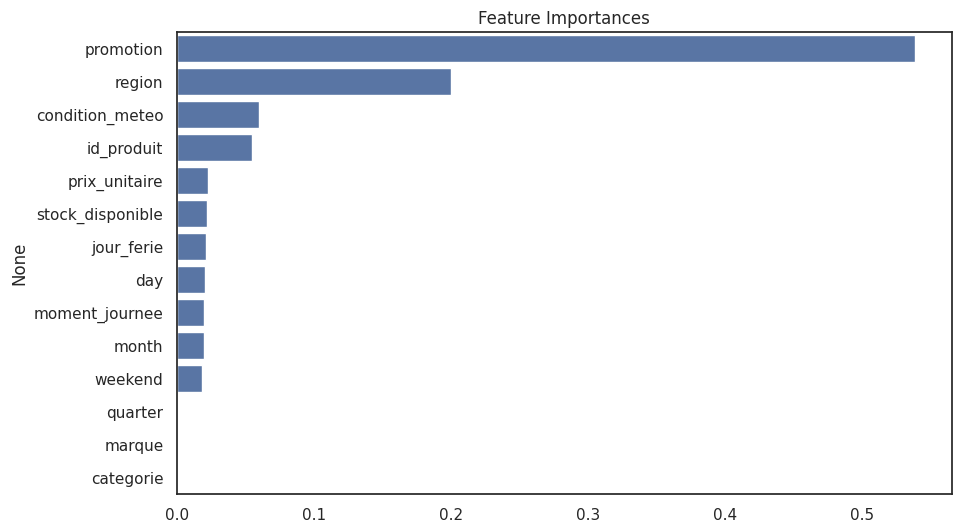

In [ ]:
X_train, y_train = op_4_train_df.drop(columns=["quantite_vendue"]), op_4_train_df["quantite_vendue"]
X_test, y_test = op_4_test_df.drop(columns=["quantite_vendue"]), op_4_test_df["quantite_vendue"]


print(f"Training model: XGBRegressor")
model = XGBRegressor(enable_categorical= True)
model.fit(X_train, y_train)  # Train model
y_pred = model.predict(X_test)  # Make predictions

# Round, floor, and ceil predictions
y_pred_round = np.round(y_pred).astype(int)
y_pred_floor = np.floor(y_pred).astype(int)
y_pred_ceil = np.ceil(y_pred).astype(int)
y_pred_custom = np.vectorize(lambda x: int(x) + 1 if x - int(x) >= 0.85 else int(x))

# Compute MAPE scores
mape = mean_absolute_percentage_error(y_test, y_pred)
mape_round = mean_absolute_percentage_error(y_test, y_pred_round)
mape_floor = mean_absolute_percentage_error(y_test, y_pred_floor)
mape_ceil = mean_absolute_percentage_error(y_test, y_pred_ceil)
round_custom = np.vectorize(lambda x: int(x) + 1 if x - int(x) >= 0.85 else int(x))
y_pred_custom = round_custom(y_pred)

mape_custom = mean_absolute_percentage_error(y_test, y_pred_custom)
# Print results
print(f" regular ===> MAPE: {mape:.4f}")
print(f" round ===> MAPE: {mape_round:.4f}")
print(f" floor ===> MAPE: {mape_floor:.4f}")
print(f" ceil ===> MAPE: {mape_ceil:.4f}")
print(f" custom ===> MAPE: {mape_custom:.4f}")
print("==" * 18)

# Plot Feature Importances
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]  # Sort indices in descending order

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices], y=X_train.columns[sorted_indices])
plt.title("Feature Importances")
plt.show()


In [ ]:
op_4_df["condition_meteo"].dropna().unique()

array(['Neigeux', 'Ensoleillé', 'Orageux', 'Nuageux', 'Pluie'],
      dtype=object)

In [ ]:
op_4_df[["date", "id_produit", "categorie", "marque"]][10:30]

,date,id_produit,categorie,marque
10,2022-01-01,ALI-102023-011,Alimentaire,Nestlé
11,2022-01-01,ÉLE-052024-013,Électronique,LG
12,2022-01-01,ÉLE-112022-037,Électronique,LG
13,2022-01-01,ÉLE-022022-010,Électronique,LG
14,2022-01-01,ÉLE-072022-020,Électronique,Huawei
15,2022-01-01,HAB-082022-007,Habillement,Adidas
16,2022-01-01,ALI-012023-005,Alimentaire,Nestlé
17,2022-01-01,HAB-072022-020,Habillement,Zara
18,2022-01-01,HAB-062022-006,Habillement,Nike
19,2022-01-01,ALI-042022-033,Alimentaire,Nestlé


Index(['prix_unitaire', 'promotion', 'jour_ferie', 'weekend',
       'stock_disponible', 'condition_meteo', 'quantite_vendue', 'month',
       'day', 'quarter'],
      dtype='object')


<Axes: >

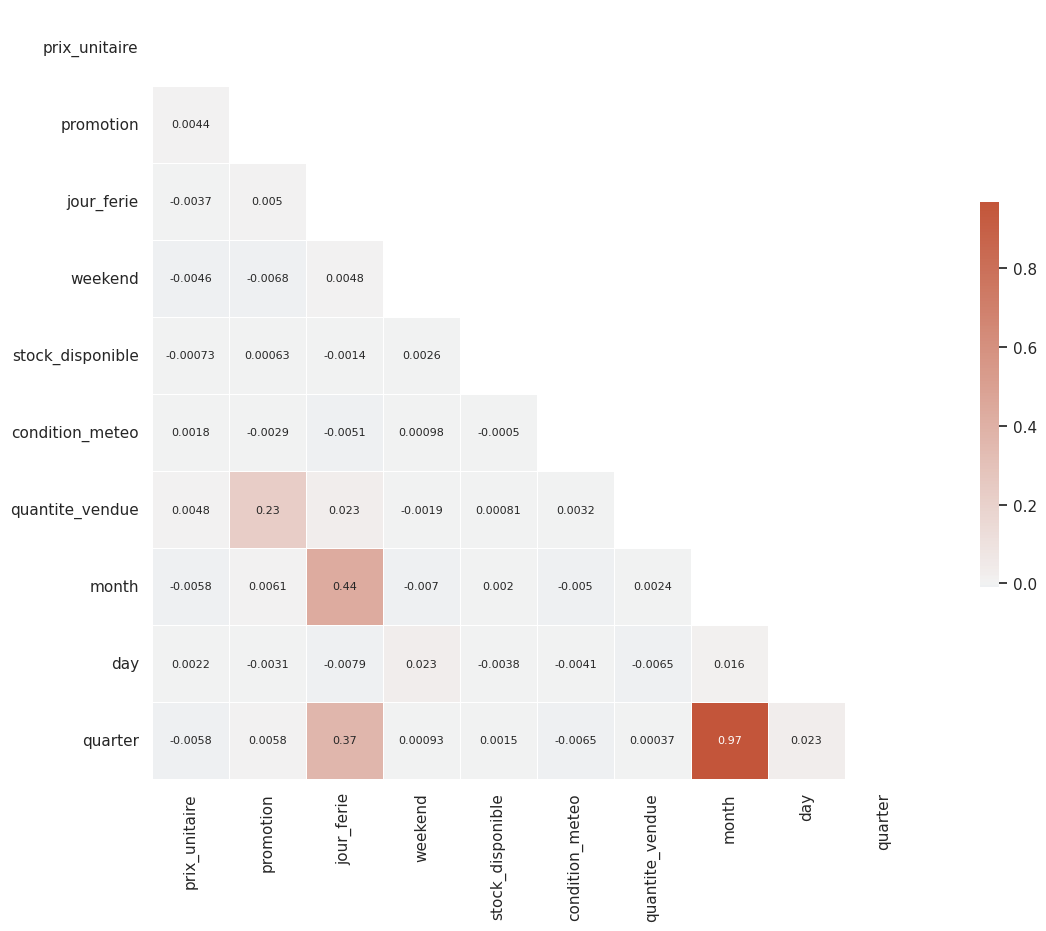

In [ ]:
#A better example (formatting used in below chart) - https://seaborn.pydata.org/examples/many_pairwise_correlations.html

sns.set_theme(style="white")

# Compute the correlation matrix
op_4_df = label_encode(op_4_df, ["condition_meteo"])
num_df = op_4_df.select_dtypes(include="number")
print(num_df.columns)
corr = num_df.corr()

# Generate a mask for the upper triangle (otherwise this looks like the square we had above and is redundant)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Generate a custom diverging colormap (choose colors here)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"fontsize":8})

#obviously many of thes variables are HIGHLY correlated. Something we may want to explore is why Average percentage viewed is negatively related to RPM

In [ ]:
print(op_4_df[["date", "id_produit", "marque"]].sort_values(by=["date"])[20:40])

          date      id_produit     marque
74  2022-01-01  HAB-012022-013       Nike
73  2022-01-01             NaN  Kellogg's
72  2022-01-01             NaN  Coca-Cola
71  2022-01-01  ÉLE-112022-034     Huawei
70  2022-01-01  ALI-052024-014  Coca-Cola
69  2022-01-01  HAB-032022-048       Zara
68  2022-01-01  ÉLE-062024-048      Apple
67  2022-01-01  ALI-052024-018  Kellogg's
66  2022-01-01  HAB-052022-046       Nike
79  2022-01-01  HAB-032023-044     Levi's
65  2022-01-01  ÉLE-062023-040         LG
95  2022-01-01  HAB-052024-040       Nike
97  2022-01-01  ÉLE-062023-014    Samsung
126 2022-01-01  ALI-032024-008   Unilever
125 2022-01-01  HAB-052024-039     Levi's
124 2022-01-01  ÉLE-052023-049      Apple
123 2022-01-01             NaN     Adidas
122 2022-01-01  HAB-052022-009        H&M
121 2022-01-01  ÉLE-042022-042      Apple
120 2022-01-01  HAB-052022-042       Zara


In [ ]:
def replace_marque(row):
    if pd.isna(row['marque']) and row['id_produit'] in marque_to_product:
        return marque_to_product[row['id_produit']][0]  # Replace with first marque if found
    return row['marque']  # Keep the original marque if not found



def option3(df):
  option3_df = df.copy()

  option3_df = fill_weekend(option3_df)

  # option3_df = drop_columns(option3_df, ["condition_meteo","region", "moment_journee", "stock_disponible"])
  # option3_df = drop_null_values_columns(option3_df, ["marque", "id_produit"])
  option3_df['marque'] = option3_df.apply(replace_marque, axis=1)
  # option3_df = drop_null_values_columns(option3_df, ["quantite_vendue"])
  option3_df["date"] = pd.to_datetime(option3_df["date"])
  option3_df["month"] = option3_df["date"].dt.month
  option3_df["day"] = option3_df["date"].dt.day
  option3_df["quarter"] = option3_df["date"].dt.quarter
  option3_df = drop_columns(option3_df, ["date"])
  option3_df = impute_jour_ferie(option3_df)
  # option3_df = impute_catrgories_ml(option3_df, "jour_ferie", ["weekend", "month"])
  option3_df = impute_catrgories_ml(option3_df, "promotion", ["weekend", "month", "day", "jour_ferie"])
  # option3_df = impute_nums_ml(option3_df, "prix_unitaire", ["jour_ferie", "promotion", "weekend"], model_type="linear")
  # option3_df = impute_column_randomly(option3_df, "prix_unitaire")
  # if "quantite_vendue" in df.columns:
    # option3_df = impute_nums_ml(option3_df, "quantite_vendue", ["promotion", "weekend"], model_type="linear")
  # option3_df = impute_nums_ml(option3_df, "stock_disponible", ["promotion", "weekend", "prix_unitaire"], model_type="linear")
  # option3_df = impute_column_randomly(option3_df, "stock_disponible")

  '''=============== encoding =============='''

  # option3_df = target_encode(option3_df, "id_produit", "quantite_vendue")
  # option3_df = target_encode(option3_df, "marque", "quantite_vendue")
  option3_df = label_encode(option3_df, ["marque"])
  option3_df, one_encoded_column = one_hot_encode(option3_df, ["categorie"])

  option3_df = impute_catrgories_ml(option3_df, "id_produit", one_encoded_column + ['marque', 'prix_unitaire', 'promotion'])
  option3_df = label_encode(option3_df, ["id_produit"])
  option3_df = drop_null_values_columns(option3_df, ["quantite_vendue"])

  option3_df = impute_nums_ml(option3_df, "prix_unitaire", ["id_produit", "marque", "jour_ferie", "promotion", "weekend"], model_type="linear")

  print(nulls_summary_table(option3_df))
  print("--"*25)
  print(f"Shape : {option3_df.shape}")
  print("=="*25)

  return option3_df



# Assembling Train set
X_train_copy = X_train_final.copy()
y_train_copy = y_train_final.copy()
trainV3 = pd.concat([X_train_copy, y_train_copy], axis=1)
print("train set ↓ \n")
option3_train_df = option3(trainV3)
X_train, y_train = option3_train_df.drop(columns=["quantite_vendue"]), option3_train_df["quantite_vendue"]

# Assembling Test set
X_test_copy = X_test_final.copy()
y_test_copy = y_test_final.copy()
testV3 = pd.concat([X_test_copy, y_test_copy], axis=1)
print("\n test set ↓ \n")
option3_test_df = option3(testV3)
X_test, y_test = option3_test_df.drop(columns=["quantite_vendue"]), option3_test_df["quantite_vendue"]

print(f"Any nulls? {np.any(np.isnan(y_train))}")  # Check for NaN
print(f"Any infinity? {np.any(np.isinf(y_train))}")  # Check for infinity
print("=="*25)
print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test data shape: X_test={X_test.shape}, y_test={y_test.shape}")

train set ↓ 

0:	learn: 0.6931400	total: 8.93ms	remaining: 437ms
49:	learn: 0.6928866	total: 198ms	remaining: 0us
                        null_count  null_percentage
id_produit                       0         0.000000
marque                           0         0.000000
prix_unitaire                 2883         0.053657
promotion                        0         0.000000
jour_ferie                       0         0.000000
weekend                          0         0.000000
quantite_vendue                  0         0.000000
month                            0         0.000000
day                              0         0.000000
quarter                          0         0.000000
categorie_Alimentaire            0         0.000000
categorie_Habillement            0         0.000000
categorie_Électronique           0         0.000000
--------------------------------------------------
Shape : (53730, 13)

 test set ↓ 

0:	learn: 0.6931230	total: 1.39ms	remaining: 68.1ms
49:	learn: 0.6918390

Training model: XGBRegressor
 regular ===> MAPE: 0.3105
 round ===> MAPE: 0.3103
 floor ===> MAPE: 0.2971
 ceil ===> MAPE: 0.3251
 custom ===> MAPE: 0.3009


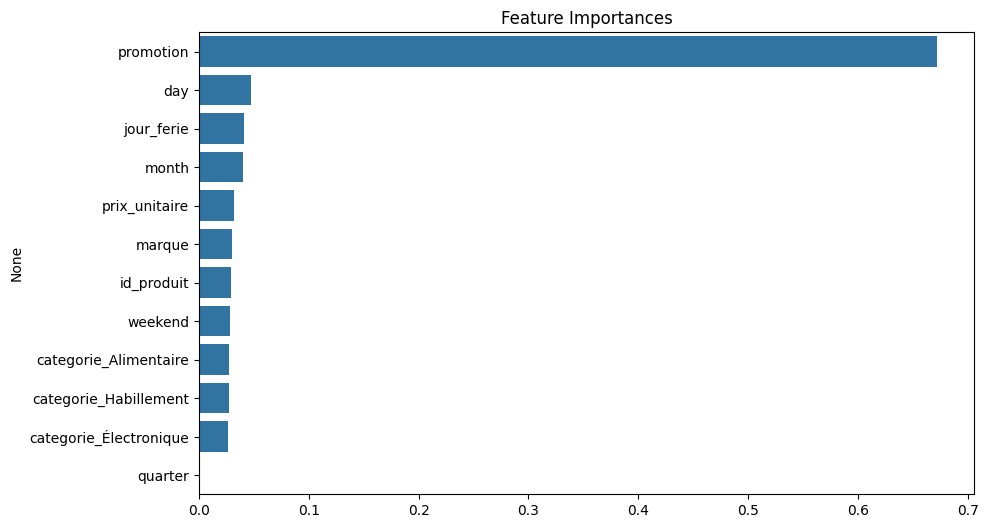

In [ ]:
# Convert all object columns to category
for col in X_train.select_dtypes(include="object").columns:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

print(f"Training model: XGBRegressor")
model = XGBRegressor(enable_categorical= True)
model.fit(X_train, y_train)  # Train model
y_pred = model.predict(X_test)  # Make predictions

# Round, floor, and ceil predictions
y_pred_round = np.round(y_pred).astype(int)
y_pred_floor = np.floor(y_pred).astype(int)
y_pred_ceil = np.ceil(y_pred).astype(int)
y_pred_custom = np.vectorize(lambda x: int(x) + 1 if x - int(x) >= 0.85 else int(x))

# Compute MAPE scores
mape = mean_absolute_percentage_error(y_test, y_pred)
mape_round = mean_absolute_percentage_error(y_test, y_pred_round)
mape_floor = mean_absolute_percentage_error(y_test, y_pred_floor)
mape_ceil = mean_absolute_percentage_error(y_test, y_pred_ceil)
round_custom = np.vectorize(lambda x: int(x) + 1 if x - int(x) >= 0.85 else int(x))
y_pred_custom = round_custom(y_pred)

mape_custom = mean_absolute_percentage_error(y_test, y_pred_custom)
# Print results
print(f" regular ===> MAPE: {mape:.4f}")
print(f" round ===> MAPE: {mape_round:.4f}")
print(f" floor ===> MAPE: {mape_floor:.4f}")
print(f" ceil ===> MAPE: {mape_ceil:.4f}")
print(f" custom ===> MAPE: {mape_custom:.4f}")
print("==" * 18)

# Plot Feature Importances
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]  # Sort indices in descending order

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices], y=X_train.columns[sorted_indices])
plt.title("Feature Importances")
plt.show()


In [ ]:
X_train["prix_unitaire"].astype(float)
X_test["prix_unitaire"].astype(float)
models_params = {
    "CatBoost Regressor": {
        "model": CatBoostRegressor(verbose=0, cat_features=['jour_ferie', 'weekend', 'month', 'marque', "day"]),
        "params": {
            "iterations": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "depth": [3, 5, 7],
            "l2_leaf_reg": [1, 3, 5],
            "subsample": [0.8, 1.0],
            "random_state": [42]
        }
    },



    "XGBoost Regressor": {
        "model": XGBRegressor(enable_categorical=True),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "alpha": [0, 1, 10],
            "reg_lambda": [0, 1, 10],
            "random_state": [42]
        }
    },

    "LightGBM Regressor": {
        "model": LGBMRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [-1, 5, 10],
            "num_leaves": [31, 50, 100],
            "subsample": [0.8, 1.0],
            "verbose":[-1],
            "colsample_bytree": [0.8, 1.0],
            "random_state": [42]
        }
    },

    "Gradient Boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "min_samples_split": [2, 5, 10],
            "subsample": [0.8, 1.0],
            "random_state": [42]
        }
    },

    "AdaBoost": {
        "model": AdaBoostRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0],
            "loss": ["linear", "square", "exponential"],
            "random_state": [42]
        }
    },

    "Extra Trees": {
        "model": ExtraTreesRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 5, 10, 20, 50],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
            "max_features": ["sqrt", "log2"],
            "bootstrap": [True, False],
            "random_state": [42]
        }
    },

    "Hist Gradient Boosting": {
        "model": HistGradientBoostingRegressor(),
        "params": {
            "learning_rate": [0.01, 0.1, 0.2],
            "max_iter": [50, 100, 200],
            "max_depth": [3, 5, 7],
            "min_samples_leaf": [1, 2, 5],
            "max_bins": [255, 511],
            "random_state": [42]
        }
    },
      "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [50, 100, 200, 500],
            "max_depth": [None, 5, 10, 20, 50],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
            "max_features": ["sqrt", "log2"],
            "bootstrap": [True, False],
            "random_state": [42]
        }
      }
}



from sklearn.model_selection import RandomizedSearchCV

# scaled_X_train = feature_scaling(X_train, X_train.columns, option="robust")
# scaled_X_test = feature_scaling(X_test, X_test.columns, option="robust")
# Loop through each model in models_params
for model_name, params in models_params.items():
    model = params["model"]
    param_dist = params["params"]

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,  # Number of random combinations to try
        cv=5,
        scoring='neg_mean_absolute_percentage_error',  # Scoring with MAPE
        verbose=0,  # Print progress (set to 1 or 2 for more detail)
        random_state=42,
        n_jobs=-1
    )

    # Train the model with the training fold data
    if model_name == "Lasso" or model_name == "Linear Regression":
      print(X_train.shape)
      print(y_train.shape)
      print(X_train.isnull().sum())
      print(y_train.isnull().sum())
      random_search.fit(X_train, y_train)
    else:
      random_search.fit(X_train, y_train)

    # Get the best model from the search
    best_model = random_search.best_estimator_

    # Predict on the test fold
    if model_name == "Lasso" or model_name == "Linear Regression":
      y_pred = best_model.predict(X_test)
    else:
      y_pred = best_model.predict(X_test)
    y_pred_round = np.round(y_pred).astype(int)
    y_pred_floor = np.floor(y_pred).astype(int)
    y_pred_ceil = np.ceil(y_pred).astype(int)

    # Calculate MAPE for this fold and store it
    mape_score = mape_function(y_test, y_pred)

    # Print MAPE for this fold
    print(f"{model_name} =====>  regular MAPE: {mape_score:.4f}")
    print(f"{model_name} =====>  round MAPE: {mape_function(y_test, y_pred_round):.4f}")
    print(f"{model_name} =====>  floor MAPE: {mape_function(y_test, y_pred_floor):.4f}")
    print(f"{model_name} =====>  ceil MAPE: {mape_function(y_test, y_pred_ceil):.4f}")

    print(f"{model_name} Best params :{random_search.best_params_}")
    print("="*66)


CatBoost Regressor =====>  regular MAPE: 0.2848
CatBoost Regressor =====>  round MAPE: 0.2857
CatBoost Regressor =====>  floor MAPE: 0.2720
CatBoost Regressor =====>  ceil MAPE: 0.2964
CatBoost Regressor Best params :{'subsample': 1.0, 'random_state': 42, 'learning_rate': 0.2, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 3}
XGBoost Regressor =====>  regular MAPE: 0.3009
XGBoost Regressor =====>  round MAPE: 0.3009
XGBoost Regressor =====>  floor MAPE: 0.2867
XGBoost Regressor =====>  ceil MAPE: 0.3156
XGBoost Regressor Best params :{'subsample': 0.8, 'reg_lambda': 10, 'random_state': 42, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'alpha': 0}
LightGBM Regressor =====>  regular MAPE: 0.2847
LightGBM Regressor =====>  round MAPE: 0.2854
LightGBM Regressor =====>  floor MAPE: 0.2723
LightGBM Regressor =====>  ceil MAPE: 0.2966
LightGBM Regressor Best params :{'verbose': -1, 'subsample': 0.8, 'random_state': 42, 'num_leaves': 100, 'n_estimators': 20

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py", line 659, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1064, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


## 4

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Separate rows with and without missing target values
train_with_target = train[train['quantite_vendue'].notna()]  # Rows with no missing target
train_missing_target = train[train['quantite_vendue'].isna()]  # Rows with missing target

# Step 2: Split the data with no missing target into training and test sets
X = train_with_target.drop(['quantite_vendue'], axis=1)  # Exclude the target variable
y = train_with_target['quantite_vendue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

# Step 3: Add rows with missing target back to the training set
X_train_final = pd.concat([X_train, train_missing_target.drop(['quantite_vendue'], axis=1)])
y_train_final = pd.concat([y_train, train_missing_target['quantite_vendue']])

X_test_final = X_test.copy()
y_test_final = y_test.copy()
# Print shapes to verify
print(f"Training data shape: X_train={X_train_final.shape}, y_train={y_train_final.shape}")
print(f"Test data shape: X_test={X_test_final.shape}, y_test={y_test_final.shape}")

Training data shape: X_train=(65137, 12), y_train=(65137,)
Test data shape: X_test=(17910, 12), y_test=(17910,)


In [ ]:
'''# Group by 'id_produit' and aggregate unique brands
shared_products = X_train_final.groupby('id_produit')['marque'].nunique().reset_index()

# Filter products shared by two or more brands
shared_products = shared_products[shared_products['marque'] > 1]

# Display product IDs with multiple brands
print("Products shared by two or more brands:")
print(shared_products)

# Optional: To display the specific brands for these shared products
if not shared_products.empty:
    shared_product_ids = shared_products['id_produit']
    result = X_train_final[X_train_final['id_produit'].isin(shared_product_ids)].groupby('id_produit')['marque'].unique()
    print("\nBrands for shared products:")
    print(result)'''


'# Group by \'id_produit\' and aggregate unique brands\nshared_products = X_train_final.groupby(\'id_produit\')[\'marque\'].nunique().reset_index()\n\n# Filter products shared by two or more brands\nshared_products = shared_products[shared_products[\'marque\'] > 1]\n\n# Display product IDs with multiple brands\nprint("Products shared by two or more brands:")\nprint(shared_products)\n\n# Optional: To display the specific brands for these shared products\nif not shared_products.empty:\n    shared_product_ids = shared_products[\'id_produit\']\n    result = X_train_final[X_train_final[\'id_produit\'].isin(shared_product_ids)].groupby(\'id_produit\')[\'marque\'].unique()\n    print("\nBrands for shared products:")\n    print(result)'

In [ ]:
# (product -> marque)
marque_to_product = train.dropna(subset=['id_produit', 'marque']).groupby('id_produit')['marque'].unique().to_dict()

'''marque_to_impute = train[["id_produit", "marque"]][train["marque"].isna()].sort_values("id_produit")

marque_to_impute['marque'] = marque_to_impute['id_produit'].map(lambda x: marque_to_product.get(x, np.nan))
'''
# marque_to_product

'marque_to_impute = train[["id_produit", "marque"]][train["marque"].isna()].sort_values("id_produit")\n\nmarque_to_impute[\'marque\'] = marque_to_impute[\'id_produit\'].map(lambda x: marque_to_product.get(x, np.nan))\n'

In [ ]:
trainV4 = pd.concat([X_train_final, y_train_final], axis=1)
testV4 = pd.concat([X_test_final, y_test_final], axis=1)

### Transformation

#### V17

In [ ]:
'''def replace_marque(row):
    if pd.isna(row['marque']) and row['id_produit'] in marque_to_product:
        return marque_to_product[row['id_produit']][0]  # Replace with first marque if found
    return row['marque']  # Keep the original marque if not found

def fill_condition_meteo(group):
    mode_value = group['condition_meteo'].mode()
    if not mode_value.empty:
        return group['condition_meteo'].fillna(mode_value[0])
    else:
        return group['condition_meteo'].fillna('Unknown')


op_4_train_df = trainV4.copy()
op_4_train_df["date"] = pd.to_datetime(op_4_train_df["date"])
op_4_train_df = fill_weekend(op_4_train_df)
op_4_train_df['marque'] = op_4_train_df.apply(replace_marque, axis=1)
op_4_train_df['marque'] = op_4_train_df.groupby(
      op_4_train_df['id_produit'].fillna(op_4_train_df['categorie'])
  )['marque'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
  )
op_4_train_df["month"] = op_4_train_df["date"].dt.month
op_4_train_df["day"] = op_4_train_df["date"].dt.day
op_4_train_df["quarter"] = op_4_train_df["date"].dt.quarter
op_4_train_df = impute_jour_ferie(op_4_train_df)
op_4_train_df = impute_promotion(op_4_train_df)
op_4_train_df['prix_unitaire'] = op_4_train_df.groupby(
      op_4_train_df['id_produit'].fillna(op_4_train_df['categorie'])
  )['prix_unitaire'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean())
  )

op_4_train_df['prix_unitaire'] = np.log1p(op_4_train_df['prix_unitaire'])

op_4_train_df['stock_disponible'] = op_4_train_df.groupby(
    op_4_train_df['id_produit'].fillna(op_4_train_df['categorie'])
)['stock_disponible'].transform(
    lambda x: x.fillna(x.mean())
)

op_4_train_df['stock_disponible'] = np.log1p(op_4_train_df['stock_disponible'])

# op_4_train_df['promotion_stock_ratio'] = op_4_train_df['stock_disponible'] / (op_4_train_df['promotion'] + 1)


# brand_avg_price = op_4_train_df.groupby('marque')['prix_unitaire'].mean().reset_index()
# op_4_train_df = op_4_train_df.merge(brand_avg_price, on='marque', suffixes=('', '_avg_marque'))

np.random.seed(42)
op_4_train_df["condition_meteo"] = op_4_train_df["condition_meteo"].fillna(np.random.choice(op_4_train_df["condition_meteo"].dropna().unique()))
op_4_train_df["moment_journee"] = op_4_train_df["moment_journee"].fillna(np.random.choice(op_4_train_df["moment_journee"].dropna().unique()))
op_4_train_df["region"] = op_4_train_df["region"].fillna(np.random.choice(op_4_train_df["region"].dropna().unique()))


# op_4_train_df = impute_nums_ml(op_4_train_df, "quantite_vendue", ["promotion", "weekend", "prix_unitaire"], model_type="random_forest")
op_4_train_df = drop_null_values_columns(op_4_train_df, ["id_produit", "quantite_vendue"])
op_4_train_df = drop_columns(op_4_train_df, ["date"])

op_4_train_df = winsorize(op_4_train_df, 'prix_unitaire', upper=85, lower=15)
op_4_train_df = winsorize(op_4_train_df, 'stock_disponible', upper=85, lower=15)
op_4_train_df['promotion_stock_ratio'] = op_4_train_df['stock_disponible'] / (op_4_train_df['promotion'] + 1)


op_4_train_df['id_number'] = op_4_train_df['id_produit'].str.split('-').str[-1].astype(int)
op_4_train_df['id_month'] = op_4_train_df['id_produit'].str.split('-').str[1].str[:2].astype(int)
op_4_train_df['id_year'] = op_4_train_df['id_produit'].str.split('-').str[1].str[2:].astype(int)

print(nulls_summary_table(op_4_train_df))
print(f"Shape of train {op_4_train_df.shape}")'''

                       null_count  null_percentage
id_produit                      0              0.0
categorie                       0              0.0
marque                          0              0.0
prix_unitaire                   0              0.0
promotion                       0              0.0
jour_ferie                      0              0.0
weekend                         0              0.0
stock_disponible                0              0.0
condition_meteo                 0              0.0
region                          0              0.0
moment_journee                  0              0.0
quantite_vendue                 0              0.0
month                           0              0.0
day                             0              0.0
quarter                         0              0.0
promotion_stock_ratio           0              0.0
id_number                       0              0.0
id_month                        0              0.0
id_year                        

In [ ]:
'''# Combine X_train and y_train
# Step 1: Sort the target variable (quantite_vendue) while preserving the original indices
sorted_df = op_4_train_df[['quantite_vendue']].sort_values(by='quantite_vendue')
# print(sorted_df.head())

# Step 2: Divide the sorted DataFrame into bins
num_bins = 9
bin_size = len(sorted_df) // num_bins

# Step 2.1: Create bin labels
bin_labels = np.repeat(range(num_bins), bin_size)

# Step 2.2: Handle the remainder and assign remaining values to the last bin
remaining = len(sorted_df) % num_bins
if remaining > 0:
    bin_labels = np.append(bin_labels, np.repeat(num_bins - 1, remaining))

# Step 3: Assign bins to the sorted DataFrame
sorted_df['quantite_vendue_binned'] = bin_labels

# Step 4: Reassign the binned values to the original DataFrame using the original indices
op_4_train_df['quantite_vendue_binned'] = sorted_df['quantite_vendue_binned']

# Step 5: Verify the distribution of binned target values
# print(op_4_train_df['quantite_vendue_binned'].value_counts())

# Calculate the mean of 'quantite_vendue' for each bin
bin_means = op_4_train_df.groupby('quantite_vendue_binned')['quantite_vendue'].mean()
# Check the bin means
# print(bin_means)

# Create a dictionary to map each bin to its corresponding mean
bin_to_mean_map = dict(enumerate(bin_means))

# Map the binned values to their corresponding mean values
op_4_train_df['quantite_vendue'] = op_4_train_df['quantite_vendue_binned'].map(bin_to_mean_map)
op_4_train_df = drop_columns(op_4_train_df, ["quantite_vendue_binned"])
# Display the first 20 rows of the mapped values
# print(op_4_train_df[['quantite_vendue_binned', 'quantite_vendue', 'quantite_vendue_mapped']].head(20))
op_4_train_df[op_4_train_df["quantite_vendue"] == 30].head(5)'''

,id_produit,categorie,marque,prix_unitaire,promotion,jour_ferie,weekend,stock_disponible,condition_meteo,region,moment_journee,quantite_vendue,month,day,quarter,promotion_stock_ratio,id_number,id_month,id_year


In [ ]:
'''def replace_marque(row):
    if pd.isna(row['marque']) and row['id_produit'] in marque_to_product:
        return marque_to_product[row['id_produit']][0]  # Replace with first marque if found
    return row['marque']  # Keep the original marque if not found

def fill_condition_meteo(group):
    mode_value = group['condition_meteo'].mode()
    if not mode_value.empty:
        return group['condition_meteo'].fillna(mode_value[0])
    else:
        return group['condition_meteo'].fillna('Unknown')


op_4_test_df = testV4.copy()
op_4_test_df["date"] = pd.to_datetime(op_4_test_df["date"])
op_4_test_df = fill_weekend(op_4_test_df)
op_4_test_df['marque'] = op_4_test_df.apply(replace_marque, axis=1)
op_4_test_df['marque'] = op_4_test_df.groupby(
      op_4_test_df['id_produit'].fillna(op_4_test_df['categorie'])
  )['marque'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
  )
op_4_test_df["month"] = op_4_test_df["date"].dt.month
op_4_test_df["day"] = op_4_test_df["date"].dt.day
op_4_test_df["quarter"] = op_4_test_df["date"].dt.quarter
op_4_test_df = impute_jour_ferie(op_4_test_df)
op_4_test_df = impute_promotion(op_4_test_df)
op_4_test_df['prix_unitaire'] = op_4_test_df.groupby(
      op_4_test_df['id_produit'].fillna(op_4_test_df['categorie'])
  )['prix_unitaire'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean())
  )

op_4_test_df['prix_unitaire'] = np.log1p(op_4_test_df['prix_unitaire'])

op_4_test_df['stock_disponible'] = op_4_test_df.groupby(
    op_4_test_df['id_produit'].fillna(op_4_test_df['categorie'])
)['stock_disponible'].transform(
    lambda x: x.fillna(x.mean())
)
op_4_test_df['stock_disponible'] = np.log1p(op_4_test_df['stock_disponible'])

# op_4_test_df['promotion_stock_ratio'] = op_4_test_df['stock_disponible'] / (op_4_test_df['promotion'] + 1)


# brand_avg_price = op_4_test_df.groupby('marque')['prix_unitaire'].mean().reset_index()
# op_4_test_df = op_4_test_df.merge(brand_avg_price, on='marque', suffixes=('', '_avg_marque'))

np.random.seed(42)
op_4_test_df["condition_meteo"] = op_4_test_df["condition_meteo"].fillna(np.random.choice(op_4_test_df["condition_meteo"].dropna().unique()))
op_4_test_df["moment_journee"] = op_4_test_df["moment_journee"].fillna(np.random.choice(op_4_test_df["moment_journee"].dropna().unique()))
op_4_test_df["region"] = op_4_test_df["region"].fillna(np.random.choice(op_4_test_df["region"].dropna().unique()))

op_4_test_df = drop_null_values_columns(op_4_test_df, ["id_produit"])
op_4_test_df = drop_columns(op_4_test_df, ["date"])

op_4_test_df = winsorize(op_4_test_df, 'prix_unitaire', upper=85, lower=15)
op_4_test_df = winsorize(op_4_test_df, 'stock_disponible', upper=85, lower=15)
op_4_test_df['promotion_stock_ratio'] = op_4_test_df['stock_disponible'] / (op_4_test_df['promotion'] + 1)


op_4_test_df['id_number'] = op_4_test_df['id_produit'].str.split('-').str[-1].astype(int)
op_4_test_df['id_month'] = op_4_test_df['id_produit'].str.split('-').str[1].str[:2].astype(int)
op_4_test_df['id_year'] = op_4_test_df['id_produit'].str.split('-').str[1].str[2:].astype(int)
print(nulls_summary_table(op_4_test_df))
print(f"Shape of test {op_4_test_df.shape}")'''

                       null_count  null_percentage
id_produit                      0              0.0
categorie                       0              0.0
marque                          0              0.0
prix_unitaire                   0              0.0
promotion                       0              0.0
jour_ferie                      0              0.0
weekend                         0              0.0
stock_disponible                0              0.0
condition_meteo                 0              0.0
region                          0              0.0
moment_journee                  0              0.0
quantite_vendue                 0              0.0
month                           0              0.0
day                             0              0.0
quarter                         0              0.0
promotion_stock_ratio           0              0.0
id_number                       0              0.0
id_month                        0              0.0
id_year                        

In [ ]:
'''def replace_marque(row):
    if pd.isna(row['marque']) and row['id_produit'] in marque_to_product:
        return marque_to_product[row['id_produit']][0]  # Replace with first marque if found
    return row['marque']  # Keep the original marque if not found

def fill_condition_meteo(group):
    mode_value = group['condition_meteo'].mode()
    if not mode_value.empty:
        return group['condition_meteo'].fillna(mode_value[0])
    else:
        return group['condition_meteo'].fillna('Unknown')


op_4_sub_df = sub.copy()
op_4_sub_df["date"] = pd.to_datetime(op_4_sub_df["date"])
op_4_sub_df = fill_weekend(op_4_sub_df)
op_4_sub_df['marque'] = op_4_sub_df.apply(replace_marque, axis=1)
op_4_sub_df['marque'] = op_4_sub_df.groupby(
      op_4_sub_df['id_produit'].fillna(op_4_sub_df['categorie'])
  )['marque'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
  )
op_4_sub_df["month"] = op_4_sub_df["date"].dt.month
op_4_sub_df["day"] = op_4_sub_df["date"].dt.day
op_4_sub_df["quarter"] = op_4_sub_df["date"].dt.quarter
op_4_sub_df = impute_jour_ferie(op_4_sub_df)
op_4_sub_df = impute_promotion(op_4_sub_df)
op_4_sub_df['prix_unitaire'] = op_4_sub_df.groupby(
      op_4_sub_df['id_produit'].fillna(op_4_sub_df['categorie'])
  )['prix_unitaire'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean())
  )

# op_4_sub_df['prix_unitaire'] = np.log1p(op_4_sub_df['prix_unitaire'])

op_4_sub_df['stock_disponible'] = op_4_sub_df.groupby(
    op_4_sub_df['id_produit'].fillna(op_4_sub_df['categorie'])
)['stock_disponible'].transform(
    lambda x: x.fillna(x.mean())
)

# op_4_sub_df['stock_disponible'] = np.log1p(op_4_sub_df['stock_disponible'])

op_4_sub_df['promotion_stock_ratio'] = op_4_sub_df['stock_disponible'] / (op_4_sub_df['promotion'] + 1)

# brand_avg_price = op_4_sub_df.groupby('marque')['prix_unitaire'].mean().reset_index()
# op_4_sub_df = op_4_sub_df.merge(brand_avg_price, on='marque', suffixes=('', '_avg_marque'))
np.random.seed(42)
op_4_sub_df["condition_meteo"] = op_4_sub_df["condition_meteo"].fillna(np.random.choice(op_4_sub_df["condition_meteo"].dropna().unique()))
op_4_sub_df["moment_journee"] = op_4_sub_df["moment_journee"].fillna(np.random.choice(op_4_sub_df["moment_journee"].dropna().unique()))
op_4_sub_df["region"] = op_4_sub_df["region"].fillna(np.random.choice(op_4_sub_df["region"].dropna().unique()))


op_4_sub_df = drop_null_values_columns(op_4_sub_df, ["id_produit"])
op_4_sub_df = drop_columns(op_4_sub_df, ["date"])

op_4_sub_df = winsorize(op_4_sub_df, 'prix_unitaire', upper=85, lower=15)
op_4_sub_df = winsorize(op_4_sub_df, 'stock_disponible', upper=85, lower=15)
op_4_sub_df['promotion_stock_ratio'] = op_4_sub_df['stock_disponible'] / (op_4_sub_df['promotion'] + 1)


op_4_sub_df['id_number'] = op_4_sub_df['id_produit'].str.split('-').str[-1].astype(int)
op_4_sub_df['id_month'] = op_4_sub_df['id_produit'].str.split('-').str[1].str[:2].astype(int)
op_4_sub_df['id_year'] = op_4_sub_df['id_produit'].str.split('-').str[1].str[2:].astype(int)

print(nulls_summary_table(op_4_sub_df))
print(f"Shape of sub {op_4_sub_df.shape}")'''

                       null_count  null_percentage
id_produit                      0              0.0
categorie                       0              0.0
marque                          0              0.0
prix_unitaire                   0              0.0
promotion                       0              0.0
jour_ferie                      0              0.0
weekend                         0              0.0
stock_disponible                0              0.0
condition_meteo                 0              0.0
region                          0              0.0
moment_journee                  0              0.0
month                           0              0.0
day                             0              0.0
quarter                         0              0.0
promotion_stock_ratio           0              0.0
id_number                       0              0.0
id_month                        0              0.0
id_year                         0              0.0
Shape of sub (2576, 18)


#### V10

In [ ]:
def replace_marque(row):
    if pd.isna(row['marque']) and row['id_produit'] in marque_to_product:
        return marque_to_product[row['id_produit']][0]  # Replace with first marque if found
    return row['marque']  # Keep the original marque if not found

def fill_condition_meteo(group):
    mode_value = group['condition_meteo'].mode()
    if not mode_value.empty:
        return group['condition_meteo'].fillna(mode_value[0])
    else:
        return group['condition_meteo'].fillna('Unknown')


op_4_train_df = trainV4.copy()
op_4_train_df["date"] = pd.to_datetime(op_4_train_df["date"])
op_4_train_df = fill_weekend(op_4_train_df)
op_4_train_df['marque'] = op_4_train_df.apply(replace_marque, axis=1)
op_4_train_df['marque'] = op_4_train_df.groupby(
      op_4_train_df['id_produit'].fillna(op_4_train_df['categorie'])
  )['marque'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
  )
op_4_train_df["month"] = op_4_train_df["date"].dt.month
op_4_train_df["day"] = op_4_train_df["date"].dt.day
op_4_train_df["quarter"] = op_4_train_df["date"].dt.quarter
op_4_train_df = impute_jour_ferie(op_4_train_df)
op_4_train_df = impute_promotion(op_4_train_df)
op_4_train_df['prix_unitaire'] = op_4_train_df.groupby(
      op_4_train_df['id_produit'].fillna(op_4_train_df['categorie'])
  )['prix_unitaire'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean())
  )

op_4_train_df['prix_unitaire'] = np.log1p(op_4_train_df['prix_unitaire'])

op_4_train_df['stock_disponible'] = op_4_train_df.groupby(
    op_4_train_df['id_produit'].fillna(op_4_train_df['categorie'])
)['stock_disponible'].transform(
    lambda x: x.fillna(x.mean())
)

op_4_train_df['stock_disponible'] = np.log1p(op_4_train_df['stock_disponible'])

op_4_train_df['promotion_stock_ratio'] = op_4_train_df['stock_disponible'] / (op_4_train_df['promotion'] + 1)


# brand_avg_price = op_4_train_df.groupby('marque')['prix_unitaire'].mean().reset_index()
# op_4_train_df = op_4_train_df.merge(brand_avg_price, on='marque', suffixes=('', '_avg_marque'))

np.random.seed(42)
op_4_train_df["condition_meteo"] = op_4_train_df["condition_meteo"].fillna(np.random.choice(op_4_train_df["condition_meteo"].dropna().unique()))
op_4_train_df["moment_journee"] = op_4_train_df["moment_journee"].fillna(np.random.choice(op_4_train_df["moment_journee"].dropna().unique()))
op_4_train_df["region"] = op_4_train_df["region"].fillna(np.random.choice(op_4_train_df["region"].dropna().unique()))


# op_4_train_df = impute_nums_ml(op_4_train_df, "quantite_vendue", ["promotion", "weekend", "prix_unitaire"], model_type="random_forest")
op_4_train_df = drop_null_values_columns(op_4_train_df, ["id_produit", "quantite_vendue"])
op_4_train_df = drop_columns(op_4_train_df, ["date"])

op_4_train_df = winsorize(op_4_train_df, 'prix_unitaire', upper=85, lower=15)
op_4_train_df = winsorize(op_4_train_df, 'stock_disponible', upper=85, lower=15)


op_4_train_df['id_number'] = op_4_train_df['id_produit'].str.split('-').str[-1].astype(int)
op_4_train_df['id_month'] = op_4_train_df['id_produit'].str.split('-').str[1].str[:2].astype(int)
op_4_train_df['id_year'] = op_4_train_df['id_produit'].str.split('-').str[1].str[2:].astype(int)

print(nulls_summary_table(op_4_train_df))
print(f"Shape of train {op_4_train_df.shape}")

                       null_count  null_percentage
id_produit                      0              0.0
categorie                       0              0.0
marque                          0              0.0
prix_unitaire                   0              0.0
promotion                       0              0.0
jour_ferie                      0              0.0
weekend                         0              0.0
stock_disponible                0              0.0
condition_meteo                 0              0.0
region                          0              0.0
moment_journee                  0              0.0
quantite_vendue                 0              0.0
month                           0              0.0
day                             0              0.0
quarter                         0              0.0
promotion_stock_ratio           0              0.0
id_number                       0              0.0
id_month                        0              0.0
id_year                        

**BINS**

In [ ]:
# Combine X_train and y_train
# Step 1: Sort the target variable (quantite_vendue) while preserving the original indices
sorted_df = op_4_train_df[['quantite_vendue']].sort_values(by='quantite_vendue')
# print(sorted_df.head())

# Step 2: Divide the sorted DataFrame into bins
num_bins = 9
bin_size = len(sorted_df) // num_bins

# Step 2.1: Create bin labels
bin_labels = np.repeat(range(num_bins), bin_size)

# Step 2.2: Handle the remainder and assign remaining values to the last bin
remaining = len(sorted_df) % num_bins
if remaining > 0:
    bin_labels = np.append(bin_labels, np.repeat(num_bins - 1, remaining))

# Step 3: Assign bins to the sorted DataFrame
sorted_df['quantite_vendue_binned'] = bin_labels

# Step 4: Reassign the binned values to the original DataFrame using the original indices
op_4_train_df['quantite_vendue_binned'] = sorted_df['quantite_vendue_binned']

# Step 5: Verify the distribution of binned target values
# print(op_4_train_df['quantite_vendue_binned'].value_counts())

# Calculate the mean of 'quantite_vendue' for each bin
bin_means = op_4_train_df.groupby('quantite_vendue_binned')['quantite_vendue'].mean()
# Check the bin means
# print(bin_means)

# Create a dictionary to map each bin to its corresponding mean
bin_to_mean_map = dict(enumerate(bin_means))

# Map the binned values to their corresponding mean values
op_4_train_df['quantite_vendue'] = op_4_train_df['quantite_vendue_binned'].map(bin_to_mean_map)
op_4_train_df = drop_columns(op_4_train_df, ["quantite_vendue_binned"])
# Display the first 20 rows of the mapped values
# print(op_4_train_df[['quantite_vendue_binned', 'quantite_vendue', 'quantite_vendue_mapped']].head(20))
op_4_train_df[op_4_train_df["quantite_vendue"] == 30].head(5)

,id_produit,categorie,marque,prix_unitaire,promotion,jour_ferie,weekend,stock_disponible,condition_meteo,region,moment_journee,quantite_vendue,month,day,quarter,promotion_stock_ratio,id_number,id_month,id_year


In [ ]:
def replace_marque(row):
    if pd.isna(row['marque']) and row['id_produit'] in marque_to_product:
        return marque_to_product[row['id_produit']][0]  # Replace with first marque if found
    return row['marque']  # Keep the original marque if not found

def fill_condition_meteo(group):
    mode_value = group['condition_meteo'].mode()
    if not mode_value.empty:
        return group['condition_meteo'].fillna(mode_value[0])
    else:
        return group['condition_meteo'].fillna('Unknown')


op_4_test_df = testV4.copy()
op_4_test_df["date"] = pd.to_datetime(op_4_test_df["date"])
op_4_test_df = fill_weekend(op_4_test_df)
op_4_test_df['marque'] = op_4_test_df.apply(replace_marque, axis=1)
op_4_test_df['marque'] = op_4_test_df.groupby(
      op_4_test_df['id_produit'].fillna(op_4_test_df['categorie'])
  )['marque'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
  )
op_4_test_df["month"] = op_4_test_df["date"].dt.month
op_4_test_df["day"] = op_4_test_df["date"].dt.day
op_4_test_df["quarter"] = op_4_test_df["date"].dt.quarter
op_4_test_df = impute_jour_ferie(op_4_test_df)
op_4_test_df = impute_promotion(op_4_test_df)
op_4_test_df['prix_unitaire'] = op_4_test_df.groupby(
      op_4_test_df['id_produit'].fillna(op_4_test_df['categorie'])
  )['prix_unitaire'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean())
  )

op_4_test_df['prix_unitaire'] = np.log1p(op_4_test_df['prix_unitaire'])

op_4_test_df['stock_disponible'] = op_4_test_df.groupby(
    op_4_test_df['id_produit'].fillna(op_4_test_df['categorie'])
)['stock_disponible'].transform(
    lambda x: x.fillna(x.mean())
)
op_4_test_df['stock_disponible'] = np.log1p(op_4_test_df['stock_disponible'])

op_4_test_df['promotion_stock_ratio'] = op_4_test_df['stock_disponible'] / (op_4_test_df['promotion'] + 1)


# brand_avg_price = op_4_test_df.groupby('marque')['prix_unitaire'].mean().reset_index()
# op_4_test_df = op_4_test_df.merge(brand_avg_price, on='marque', suffixes=('', '_avg_marque'))

np.random.seed(42)
op_4_test_df["condition_meteo"] = op_4_test_df["condition_meteo"].fillna(np.random.choice(op_4_test_df["condition_meteo"].dropna().unique()))
op_4_test_df["moment_journee"] = op_4_test_df["moment_journee"].fillna(np.random.choice(op_4_test_df["moment_journee"].dropna().unique()))
op_4_test_df["region"] = op_4_test_df["region"].fillna(np.random.choice(op_4_test_df["region"].dropna().unique()))

op_4_test_df = drop_null_values_columns(op_4_test_df, ["id_produit"])
op_4_test_df = drop_columns(op_4_test_df, ["date"])

op_4_test_df = winsorize(op_4_test_df, 'prix_unitaire', upper=85, lower=15)
op_4_test_df = winsorize(op_4_test_df, 'stock_disponible', upper=85, lower=15)


op_4_test_df['id_number'] = op_4_test_df['id_produit'].str.split('-').str[-1].astype(int)
op_4_test_df['id_month'] = op_4_test_df['id_produit'].str.split('-').str[1].str[:2].astype(int)
op_4_test_df['id_year'] = op_4_test_df['id_produit'].str.split('-').str[1].str[2:].astype(int)
print(nulls_summary_table(op_4_test_df))
print(f"Shape of test {op_4_test_df.shape}")

                       null_count  null_percentage
id_produit                      0              0.0
categorie                       0              0.0
marque                          0              0.0
prix_unitaire                   0              0.0
promotion                       0              0.0
jour_ferie                      0              0.0
weekend                         0              0.0
stock_disponible                0              0.0
condition_meteo                 0              0.0
region                          0              0.0
moment_journee                  0              0.0
quantite_vendue                 0              0.0
month                           0              0.0
day                             0              0.0
quarter                         0              0.0
promotion_stock_ratio           0              0.0
id_number                       0              0.0
id_month                        0              0.0
id_year                        

In [ ]:
def replace_marque(row):
    if pd.isna(row['marque']) and row['id_produit'] in marque_to_product:
        return marque_to_product[row['id_produit']][0]  # Replace with first marque if found
    return row['marque']  # Keep the original marque if not found

def fill_condition_meteo(group):
    mode_value = group['condition_meteo'].mode()
    if not mode_value.empty:
        return group['condition_meteo'].fillna(mode_value[0])
    else:
        return group['condition_meteo'].fillna('Unknown')


op_4_sub_df = sub.copy()
op_4_sub_df["date"] = pd.to_datetime(op_4_sub_df["date"])
op_4_sub_df = fill_weekend(op_4_sub_df)
op_4_sub_df['marque'] = op_4_sub_df.apply(replace_marque, axis=1)
op_4_sub_df['marque'] = op_4_sub_df.groupby(
      op_4_sub_df['id_produit'].fillna(op_4_sub_df['categorie'])
  )['marque'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
  )
op_4_sub_df["month"] = op_4_sub_df["date"].dt.month
op_4_sub_df["day"] = op_4_sub_df["date"].dt.day
op_4_sub_df["quarter"] = op_4_sub_df["date"].dt.quarter
op_4_sub_df = impute_jour_ferie(op_4_sub_df)
op_4_sub_df = impute_promotion(op_4_sub_df)
op_4_sub_df['prix_unitaire'] = op_4_sub_df.groupby(
      op_4_sub_df['id_produit'].fillna(op_4_sub_df['categorie'])
  )['prix_unitaire'].transform(
      lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean())
  )

# op_4_sub_df['prix_unitaire'] = np.log1p(op_4_sub_df['prix_unitaire'])

op_4_sub_df['stock_disponible'] = op_4_sub_df.groupby(
    op_4_sub_df['id_produit'].fillna(op_4_sub_df['categorie'])
)['stock_disponible'].transform(
    lambda x: x.fillna(x.mean())
)

op_4_sub_df['stock_disponible'] = np.log1p(op_4_sub_df['stock_disponible'])

op_4_sub_df['promotion_stock_ratio'] = op_4_sub_df['stock_disponible'] / (op_4_sub_df['promotion'] + 1)

# brand_avg_price = op_4_sub_df.groupby('marque')['prix_unitaire'].mean().reset_index()
# op_4_sub_df = op_4_sub_df.merge(brand_avg_price, on='marque', suffixes=('', '_avg_marque'))
np.random.seed(42)
op_4_sub_df["condition_meteo"] = op_4_sub_df["condition_meteo"].fillna(np.random.choice(op_4_sub_df["condition_meteo"].dropna().unique()))
op_4_sub_df["moment_journee"] = op_4_sub_df["moment_journee"].fillna(np.random.choice(op_4_sub_df["moment_journee"].dropna().unique()))
op_4_sub_df["region"] = op_4_sub_df["region"].fillna(np.random.choice(op_4_sub_df["region"].dropna().unique()))


op_4_sub_df = drop_null_values_columns(op_4_sub_df, ["id_produit"])
op_4_sub_df = drop_columns(op_4_sub_df, ["date"])

op_4_sub_df = winsorize(op_4_sub_df, 'prix_unitaire', upper=85, lower=15)
op_4_sub_df = winsorize(op_4_sub_df, 'stock_disponible', upper=85, lower=15)


op_4_sub_df['id_number'] = op_4_sub_df['id_produit'].str.split('-').str[-1].astype(int)
op_4_sub_df['id_month'] = op_4_sub_df['id_produit'].str.split('-').str[1].str[:2].astype(int)
op_4_sub_df['id_year'] = op_4_sub_df['id_produit'].str.split('-').str[1].str[2:].astype(int)

print(nulls_summary_table(op_4_sub_df))
print(f"Shape of sub {op_4_sub_df.shape}")

                       null_count  null_percentage
id_produit                      0              0.0
categorie                       0              0.0
marque                          0              0.0
prix_unitaire                   0              0.0
promotion                       0              0.0
jour_ferie                      0              0.0
weekend                         0              0.0
stock_disponible                0              0.0
condition_meteo                 0              0.0
region                          0              0.0
moment_journee                  0              0.0
month                           0              0.0
day                             0              0.0
quarter                         0              0.0
promotion_stock_ratio           0              0.0
id_number                       0              0.0
id_month                        0              0.0
id_year                         0              0.0
Shape of sub (2576, 18)


### Encoding

In [ ]:
from category_encoders import TargetEncoder

'''========================   encoding   ========================'''

X_train, y_train = op_4_train_df.drop(columns=["quantite_vendue"]), op_4_train_df["quantite_vendue"]
X_test, y_test = op_4_test_df.drop(columns=["quantite_vendue"]), op_4_test_df["quantite_vendue"]

target_encoder = TargetEncoder(cols=['id_produit'], smoothing=7)
# Target encoding
X_train = target_encoder.fit_transform(X_train, y_train)
X_test = target_encoder.transform(X_test)
op_4_sub_df = target_encoder.transform(op_4_sub_df)


target_encoder = TargetEncoder(cols=['marque'], smoothing=7)
# Target encoding
X_train = target_encoder.fit_transform(X_train, y_train)
X_test = target_encoder.transform(X_test)
op_4_sub_df = target_encoder.transform(op_4_sub_df)



target_encoder = TargetEncoder(cols=['categorie'], smoothing=7)
# Target encoding
X_train = target_encoder.fit_transform(X_train, y_train)
X_test = target_encoder.transform(X_test)
op_4_sub_df = target_encoder.transform(op_4_sub_df)


#one hot
# columns_to_encode = ['condition_meteo', 'region', 'moment_journee', 'categorie']
# op_4_train_df, _ = one_hot_encode(op_4_train_df, columns_to_encode)
# op_4_test_df, _ = one_hot_encode(op_4_test_df, columns_to_encode)

columns_to_encode = ['condition_meteo', 'region', 'moment_journee']
for col in columns_to_encode:
    # initialize LabelEncoder for each feature column
    lbl = LabelEncoder()

    # fit label encoder on all data
    lbl.fit(X_train[col])

    # transform all the data
    X_train.loc[:, col] = lbl.transform(X_train[col]) #.astype(int)
    X_test.loc[:, col] = lbl.transform(X_test[col]) #.astype(int)
    op_4_sub_df.loc[:, col] = lbl.transform(op_4_sub_df[col]) #.astype(int)

In [ ]:
# Convert all object columns to category

for col in X_train.select_dtypes(include="object").columns:
    X_train[col] = X_train[col].astype(float)

for col in X_test.select_dtypes(include="object").columns:
    X_test[col] = X_test[col].astype(float)

for col in op_4_sub_df.select_dtypes(include="object").columns:
    op_4_sub_df[col] = op_4_sub_df[col].astype(float)

In [ ]:
print(X_test.dtypes)

id_produit               float64
categorie                float64
marque                   float64
prix_unitaire            float64
promotion                float64
jour_ferie                 int64
weekend                  float64
stock_disponible         float64
condition_meteo          float64
region                   float64
moment_journee           float64
month                      int32
day                        int32
quarter                    int32
promotion_stock_ratio    float64
id_number                  int64
id_month                   int64
id_year                    int64
dtype: object


### Training

In [ ]:
'''# Count target frequencies
freq = y_train.value_counts()

# Apply logarithmic smoothing
weights = 1 / (np.log1p(freq[y_train]) + 1)

# Rename for clarity
weights.sort_values()'''

,count
quantite_vendue,
24.057054,0.104739
24.057054,0.104739
24.057054,0.104739
24.057054,0.104739
24.057054,0.104739
...,...
19.868881,0.104750
10.883256,0.104750
19.868881,0.104750


Training model: XGBRegressor
 regular ===> MAPE: 0.2631858510693047
 round ===> MAPE: 0.26239911153327783
 floor ===> MAPE: 0.25425477523731604
 ceil ===> MAPE: 0.27389256411150287
 custom ===> MAPE: 0.2571398800662543


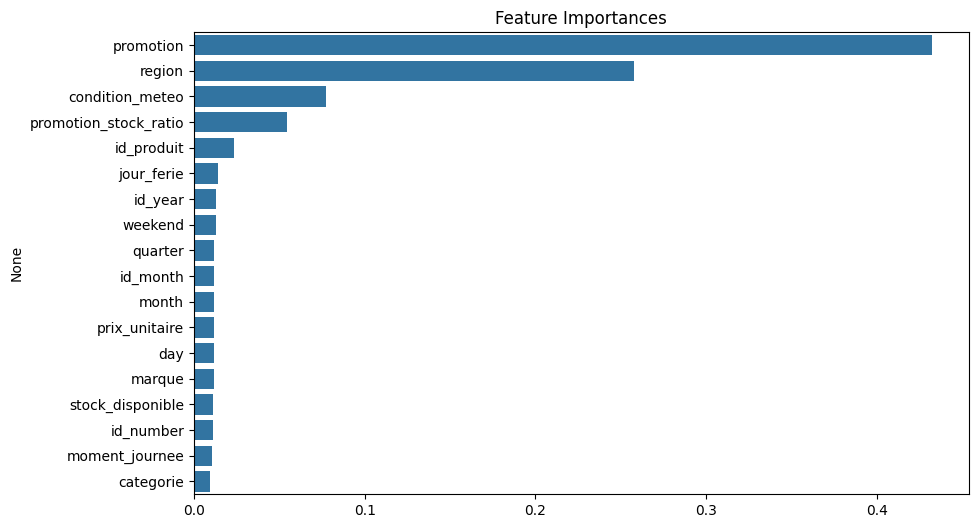

In [ ]:
np.random.seed(42)

print(f"Training model: XGBRegressor")
# n_estimators= 200, learning_rate= 0.09106526505212037, max_depth= 3, subsample= 0.9354461550643146, colsample_bytree= 0.8283283497225143, alpha= 1, reg_lambda= 0
# n_estimators= 200, learning_rate= 0.12087211604494849, max_depth= 4, subsample= 0.8453048133998438, colsample_bytree= 0.9559937382172623, alpha= 10, reg_lambda= 0
# n_estimators= 100, learning_rate= 0.1559575759467314, max_depth= 3, subsample= 0.8699396274666559, colsample_bytree= 0.8461157879933512, alpha= 0, reg_lambda= 10
# n_estimators= 200, learning_rate= 0.1352225462194719, max_depth= 3, subsample= 0.8908262484865287, colsample_bytree= 0.8760260514134094, alpha= 0, reg_lambda= 1
# n_estimators= 50, learning_rate= 0.0989885155092834, max_depth= 4, subsample= 0.9696911769938455, colsample_bytree= 0.8744873447873929, alpha= 0, reg_lambda= 10
# n_estimators=200, learning_rate=0.054542542965683435, max_depth=3, subsample=0.8378175019336114, colsample_bytree=0.8399161433048178, alpha=10, reg_lambda=0
# V10 ***(old best score)*** ===> # n_estimators= 50, learning_rate= 0.09188847418019519, max_depth= 5, subsample= 0.8037228275660006, colsample_bytree= 0.8547381773686116, alpha= 1, reg_lambda= 1
# n_estimators= 50, learning_rate= 0.09188847418019519, max_depth= 5, subsample= 0.8037228275660006, colsample_bytree= 0.8547381773686116, alpha= 1, reg_lambda= 1
# n_estimators= 388, learning_rate= 0.015698573705725142, max_depth= 4, subsample= 0.800924959034755, colsample_bytree= 0.7825811054753394, reg_alpha= 0.06910146318554289, reg_lambda= 0.13861311963703613
# V17 to do #'n_estimators': 436, 'learning_rate': 0.015942459319645295, 'max_depth': 3, 'subsample': 0.9900263755029035, 'colsample_bytree': 0.7722451225168402, 'reg_alpha': 0.0016483927075526493, 'reg_lambda': 1.9868397605678279
# to do #n_estimators= 517, learning_rate= 0.026141559191662795, max_depth= 3, subsample= 0.6130854990717682, colsample_bytree= 0.5512016641798418, reg_alpha= 9.173685748016853, reg_lambda= 2.475946822646097
#'n_estimators': 589, 'learning_rate': 0.012376207217498629, 'max_depth': 3, 'subsample': 0.6880920451029995, 'colsample_bytree': 0.8126911721086095, 'reg_alpha': 0.5890219075668033, 'reg_lambda': 0.024262547792829107
model = XGBRegressor(n_estimators= 808, learning_rate= 0.010132606912193658, max_depth= 3, subsample= 0.6951103454343047, colsample_bytree= 0.8699330643094678, reg_alpha= 8.872488427177545, reg_lambda= 0.009911239380999503)
model.fit(X_train, y_train)  # Train model
y_pred = model.predict(X_test)  # Make predictions

# Round, floor, and ceil predictions
y_pred_round = np.round(y_pred).astype(int)
y_pred_floor = np.floor(y_pred).astype(int)
y_pred_ceil = np.ceil(y_pred).astype(int)
y_pred_custom = np.vectorize(lambda x: int(x) + 1 if x - int(x) >= 0.85 else int(x))

# Compute MAPE scores
mape = mean_absolute_percentage_error(y_test, y_pred)
mape_round = mean_absolute_percentage_error(y_test, y_pred_round)
mape_floor = mean_absolute_percentage_error(y_test, y_pred_floor)
mape_ceil = mean_absolute_percentage_error(y_test, y_pred_ceil)
round_custom = np.vectorize(lambda x: int(x) + 1 if x - int(x) >= 0.85 else int(x))
y_pred_custom = round_custom(y_pred)

mape_custom = mean_absolute_percentage_error(y_test, y_pred_custom)
# Print results
print(f" regular ===> MAPE: {mape}")
print(f" round ===> MAPE: {mape_round}")
print(f" floor ===> MAPE: {mape_floor}")
print(f" ceil ===> MAPE: {mape_ceil}")
print(f" custom ===> MAPE: {mape_custom}")
print("==" * 18)

# Plot Feature Importances
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]  # Sort indices in descending order

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices], y=X_train.columns[sorted_indices])
plt.title("Feature Importances")
plt.show()

In [ ]:
y_test.value_counts().sort_values()

,count
quantite_vendue,
2.0,1
36.0,1
32.0,2
34.0,3
35.0,3
3.0,11
33.0,11
31.0,18
4.0,24


In [ ]:
pd.DataFrame(y_pred_floor)[0].value_counts().sort_values()

,count
0,
19,70
11,550
12,580
18,934
17,1655
14,2129
16,2708
13,3013
15,3835


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor

# Define the base models (we use a list of tuples where each tuple contains the name and the model)
base_learners = [
    ("XGBoost", XGBRegressor(n_estimators= 200, learning_rate= 0.09106526505212037, max_depth= 3, subsample= 0.9354461550643146, colsample_bytree= 0.8283283497225143, alpha= 1, reg_lambda= 0)),
    ("CatBoost", CatBoostRegressor(verbose = 0, iterations= 600, learning_rate= 0.03914323901400528, depth= 5, l2_leaf_reg= 5.016374620765104, subsample= 0.8981292296099813, random_strength= 4.053114057572532)),
    ("LightGBM", LGBMRegressor(verbose = -1, n_estimators= 100, learning_rate= 0.18563976853929548, max_depth= 3, num_leaves= 58, subsample= 0.8844096801319332, colsample_bytree= 0.9803059226317955)),
    ("Lasso", Lasso(alpha= 0.5560031480387373, max_iter= 2000, tol= 0.00019288454669475665)),
]

# Define the meta-model (meta-learner) which will combine the base model predictions
meta_model = LinearRegression()

# Create the Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_learners,  # Base models
    final_estimator=meta_model  # Meta model
)

# Train the stacking regressor on the training data
stacking_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred_stacking = stacking_regressor.predict(X_test)

# If you need to round the predictions (e.g., for discrete quantities)
y_pred_stacking = np.floor(y_pred_stacking)

# Evaluate the model
mape = mean_absolute_percentage_error(y_test, y_pred_stacking)
print(f"Stacking Regressor MAPE: {mape}")


Stacking Regressor MAPE: 0.2550118108466903


In [ ]:
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
# Custom MAPE scorer with rounding
def mape_floor(y_true, y_pred):
    y_pred_floor = np.floor(y_pred).astype(int)
    return mean_absolute_percentage_error(y_true, y_pred_floor)

# Create the scorer
mape_floor_scorer = make_scorer(mape_floor, greater_is_better=False)


models_params = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {
        }
    },

    "Lasso": {
        "model": Lasso(),
        "params": {
            "alpha": np.linspace(0.01, 1.0, 50),
            'max_iter': [500, 1000, 2000],
            'tol': [1e-4, 1e-3, 1e-2],
            "random_state": [42]
            }
        },

    "XGBoost Regressor": {
        "model": XGBRegressor(enable_categorical=True),
        "params": {
            "n_estimators": [50, 100, 200],  # Discrete options
            "learning_rate": np.linspace(0.01, 0.2, 3),  # Continuous range from 0.01 to 0.2
            "max_depth": [3, 5, 7],  # Discrete options
            "subsample": np.linspace(0.8, 1.0, 3),  # Continuous range from 0.8 to 1.0
            "colsample_bytree": np.linspace(0.8, 1.0, 3),  # Continuous range from 0.8 to 1.0
            "alpha": [0, 1, 10],  # Discrete options
            "reg_lambda": [0, 1, 10],  # Discrete options
            "random_state": [42]
        }
    },

    "LightGBM Regressor": {
        "model": LGBMRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],  # Discrete options
            "learning_rate": np.linspace(0.01, 0.2, 3),  # Continuous range from 0.01 to 0.2
            "max_depth": [-1, 5, 10],  # Discrete options
            "num_leaves": [31, 50, 100],  # Discrete options
            "subsample": np.linspace(0.8, 1.0, 3),  # Continuous range from 0.8 to 1.0
            "verbose": [-1],  # Discrete options
            "colsample_bytree": np.linspace(0.8, 1.0, 3),  # Continuous range from 0.8 to 1.0
            "random_state": [42]
        }
    },

    "Gradient Boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],  # Discrete options
            "learning_rate": np.linspace(0.01, 0.2, 3),  # Continuous range from 0.01 to 0.2
            "min_samples_split": [2, 5, 10],  # Discrete options
            "subsample": np.linspace(0.8, 1.0, 3),  # Continuous range from 0.8 to 1.0
            "random_state": [42]
        }
    },

    "AdaBoost": {
        "model": AdaBoostRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],  # Discrete options
            "learning_rate": np.linspace(0.01, 1.0, 3),  # Continuous range from 0.01 to 1.0
            "loss": ["linear", "square", "exponential"],  # Discrete options
            "random_state": [42]
        }
    },

    "Extra Trees": {
        "model": ExtraTreesRegressor(),
        "params": {
            "n_estimators": [50, 100, 200],  # Discrete options
            "max_depth": [None, 5, 10, 20, 50],  # Discrete options
            "min_samples_split": [2, 5, 10],  # Discrete options
            "min_samples_leaf": [1, 2, 5],  # Discrete options
            "max_features": ["sqrt", "log2"],  # Discrete options
            "bootstrap": [True, False],  # Discrete options
            "random_state": [42]
        }
    },

    "Hist Gradient Boosting": {
        "model": HistGradientBoostingRegressor(),
        "params": {
            "learning_rate": np.linspace(0.01, 0.2, 3),  # Continuous range from 0.01 to 0.2
            "max_iter": [50, 100, 200],  # Discrete options
            "max_depth": [3, 5, 7],  # Discrete options
            "min_samples_leaf": [1, 2, 5],  # Discrete options
            "max_bins": [255, 511],  # Discrete options
            "random_state": [42]
        }
    },

    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [50, 100, 200, 500],  # Discrete options
            "max_depth": [None, 5, 10, 20, 50],  # Discrete options
            "min_samples_split": [2, 5, 10],  # Discrete options
            "min_samples_leaf": [1, 2, 5],  # Discrete options
            "max_features": ["sqrt", "log2"],  # Discrete options
            "bootstrap": [True, False],  # Discrete options
            "random_state": [42]
        }
    }
}





scaled_X_train = feature_scaling(X_train, X_train.columns, option="robust")
scaled_X_test = feature_scaling(X_test, X_test.columns, option="robust")
# Loop through each model in models_params
for model_name, params in models_params.items():
    model = params["model"]
    param_dist = params["params"]

    random_search = RandomizedSearchCV(
      estimator=model,
      param_distributions=param_dist,
      n_iter=10,
      cv=5,
      scoring=mape_floor_scorer,  # Use custom scorer
      verbose=0,
      random_state=42,
      n_jobs=-1
    )

    print(f"Training {model_name}")


    # Train the model with the training fold data
    if model_name == "Lasso" or model_name == "Linear Regression":
      random_search.fit(scaled_X_train, y_train)
    else:
      random_search.fit(X_train, y_train)

    # Get the best model from the search
    best_model = random_search.best_estimator_

    # Predict on the test fold
    if model_name == "Lasso" or model_name == "Linear Regression":
      y_pred = best_model.predict(scaled_X_test)
    else:
      y_pred = best_model.predict(X_test)
    y_pred_round = np.round(y_pred).astype(int)
    y_pred_floor = np.floor(y_pred).astype(int)
    y_pred_ceil = np.ceil(y_pred).astype(int)

    # Calculate MAPE for this fold and store it
    mape_score = mape_function(y_test, y_pred)

    # Print MAPE for this fold
    print(f"{model_name} =====>  regular MAPE: {mape_score:.4f}")
    print(f"{model_name} =====>  round MAPE: {mape_function(y_test, y_pred_round):.4f}")
    print(f"{model_name} =====>  floor MAPE: {mape_function(y_test, y_pred_floor):.4f}")
    print(f"{model_name} =====>  ceil MAPE: {mape_function(y_test, y_pred_ceil):.4f}")

    print(f"{model_name} Best params :{random_search.best_params_}")
    print("="*66)


Training Linear Regression
Linear Regression =====>  regular MAPE: 0.2786
Linear Regression =====>  round MAPE: 0.2776
Linear Regression =====>  floor MAPE: 0.2689
Linear Regression =====>  ceil MAPE: 0.2908
Linear Regression Best params :{}
Training Lasso
Lasso =====>  regular MAPE: 0.2826
Lasso =====>  round MAPE: 0.2860
Lasso =====>  floor MAPE: 0.2662
Lasso =====>  ceil MAPE: 0.2860
Lasso Best params :{'tol': 0.0001, 'random_state': 42, 'max_iter': 500, 'alpha': 0.2726530612244898}
Training XGBoost Regressor
XGBoost Regressor =====>  regular MAPE: 0.2678
XGBoost Regressor =====>  round MAPE: 0.2678
XGBoost Regressor =====>  floor MAPE: 0.2572
XGBoost Regressor =====>  ceil MAPE: 0.2791
XGBoost Regressor Best params :{'subsample': 0.8, 'reg_lambda': 10, 'random_state': 42, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.105, 'colsample_bytree': 0.9, 'alpha': 0}
Training LightGBM Regressor
LightGBM Regressor =====>  regular MAPE: 0.2671
LightGBM Regressor =====>  round MAPE: 0

# Optuna

In [ ]:
import numpy as np
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Models and Parameters
models_params = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },

    "CatBoost": {
        "model": None,  # Placeholder since we instantiate CatBoost dynamically
        "params": {
            "iterations": lambda trial: trial.suggest_int("iterations", 100, 1000, step=100),
            "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.01, 0.3),
            "depth": lambda trial: trial.suggest_int("depth", 4, 10),
            "l2_leaf_reg": lambda trial: trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
            "subsample": lambda trial: trial.suggest_float("subsample", 0.6, 1.0),
            "random_strength": lambda trial: trial.suggest_float("random_strength", 0.0, 10.0),
        }
    },
    "Ridge": {
        "model": Ridge(),
        "params":{
            "alpha": lambda trial: trial.suggest_float("alpha", 1e-3, 10.0, log=True)
        }
    },

    "Lasso": {
        "model": Lasso(),
        "params": {
            "alpha": lambda trial: trial.suggest_float("alpha", 0.01, 1.0),
            "max_iter": lambda trial: trial.suggest_int("max_iter", 500, 2000, step=500),
            "tol": lambda trial: trial.suggest_float("tol", 1e-4, 1e-2)
        }
    },

    "XGBoost Regressor": {
        "model": XGBRegressor(),
        "params": {
            "n_estimators": lambda trial: trial.suggest_int('n_estimators', 100, 1000),
            "learning_rate": lambda trial: trial.suggest_float('learning_rate', 0.01, 0.3),
            "max_depth": lambda trial: trial.suggest_int('max_depth', 3, 10),
            "subsample": lambda trial: trial.suggest_float('subsample', 0.5, 1.0),
            "colsample_bytree": lambda trial: trial.suggest_float('colsample_bytree', 0.5, 1.0),
            "alpha": lambda trial: trial.suggest_float('reg_alpha', 1e-4, 10.0),
            "reg_lambda": lambda trial: trial.suggest_float('reg_lambda', 1e-4, 10.0)
        }
    },

    "LightGBM Regressor": {
        "model": LGBMRegressor(verbose=-1),
        "params": {
            "n_estimators": lambda trial: trial.suggest_int("n_estimators", 50, 200, step=50),
            "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.01, 0.2),
            "max_depth": lambda trial: trial.suggest_int("max_depth", -1, 10),
            "num_leaves": lambda trial: trial.suggest_int("num_leaves", 31, 100),
            "subsample": lambda trial: trial.suggest_float("subsample", 0.8, 1.0),
            "colsample_bytree": lambda trial: trial.suggest_float("colsample_bytree", 0.8, 1.0)
        }
    },

    "Gradient Boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": lambda trial: trial.suggest_int("n_estimators", 50, 200, step=50),
            "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.01, 0.2),
            "min_samples_split": lambda trial: trial.suggest_int("min_samples_split", 2, 10),
            "subsample": lambda trial: trial.suggest_float("subsample", 0.8, 1.0)
        }
    },

    "AdaBoost": {
        "model": AdaBoostRegressor(),
        "params": {
            "n_estimators": lambda trial: trial.suggest_int("n_estimators", 50, 200, step=50),
            "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.01, 1.0),
            "loss": lambda trial: trial.suggest_categorical("loss", ["linear", "square", "exponential"])
        }
    },

    "Hist Gradient Boosting": {
        "model": HistGradientBoostingRegressor(),
        "params": {
            "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.01, 0.2),
            "max_iter": lambda trial: trial.suggest_int("max_iter", 50, 200, step=50),
            "max_depth": lambda trial: trial.suggest_int("max_depth", 3, 7),
            "min_samples_leaf": lambda trial: trial.suggest_int("min_samples_leaf", 1, 5),
            "max_bins": lambda trial: trial.suggest_int("max_bins", 1, 255)
        }
    },
}

# Objective Function for Optuna
def objective(trial, model_name, model_info):
    param_funcs = model_info["params"]
    params = {key: func(trial) for key, func in param_funcs.items()}  # Suggest parameters dynamically

    # Handle dynamic instantiation for CatBoost
    if model_name == "CatBoost":
        model = CatBoostRegressor(**params, verbose=0)
    else:
        model = model_info["model"].__class__(**params)

    model.fit(X_train, y_train)
    y_pred = np.floor(model.predict(X_test))  # Adjust predictions if needed

    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mape

# Loop through all models and perform optimization
best_models = {}
optimized_models = {}  # To store the trained models

for model_name, model_info in models_params.items():
    print(f"Optimizing {model_name}...")

    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, model_name, model_info), n_trials=50)

    best_models[model_name] = {
        "best_params": study.best_trial.params,
        "best_value": study.best_trial.value
    }

    # Instantiate and train the best model with optimal parameters
    best_params = study.best_trial.params
    if model_name == "CatBoost":
        optimized_model = CatBoostRegressor(**best_params, verbose=0)
    else:
        optimized_model = model_info["model"].__class__(**best_params)

    optimized_model.fit(X_train, y_train)
    optimized_models[model_name] = optimized_model

    print(f"Best parameters for {model_name}: {study.best_trial.params}")
    print(f"Best MAPE: {study.best_trial.value}\n")

# Print summary of results
print("Summary of Best Models:")
for model, result in best_models.items():
    print(f"{model}: MAPE={result['best_value']}, Params={result['best_params']}")

# `optimized_models` now contains trained models for later use (e.g., ensembling)
Optimizing Linear Regression...
Best parameters for Linear Regression: {}
Best MAPE: 0.2695641182823098

Optimizing CatBoost...
Best parameters for CatBoost: {'iterations': 200, 'learning_rate': 0.1288716160623222, 'depth': 4, 'l2_leaf_reg': 6.077044654602166, 'subsample': 0.7749748371300657, 'random_strength': 5.0374588442600015}
Best MAPE: 0.2540901793302305

Optimizing Ridge...
Best parameters for Ridge: {'alpha': 2.0795908708614457}
Best MAPE: 0.269554648680545

Optimizing Lasso...
Best parameters for Lasso: {'alpha': 0.5356470932876214, 'max_iter': 2000, 'tol': 0.0012385568882280484}
Best MAPE: 0.2693801154560274

Optimizing XGBoost Regressor...
Best parameters for XGBoost Regressor: {'n_estimators': 191, 'learning_rate': 0.032201173029940806, 'max_depth': 5, 'subsample': 0.7779886655059746, 'colsample_bytree': 0.9031568533873594, 'reg_alpha': 7.70381385534135, 'reg_lambda': 7.585695651236986}
Best MAPE: 0.2544848966316513

Best parameters for LightGBM Regressor: {'n_estimators': 150, 'learning_rate': 0.13138640088150935, 'max_depth': 2, 'num_leaves': 86, 'subsample': 0.8403670216638772, 'colsample_bytree': 0.9458665300381638}
Best MAPE: 0.2537632150167251


Optimizing Linear Regression...
Best parameters for Linear Regression: {}
Best MAPE: 0.2695641182823098

Optimizing CatBoost...
Best parameters for CatBoost: {'iterations': 200, 'learning_rate': 0.1288716160623222, 'depth': 4, 'l2_leaf_reg': 6.077044654602166, 'subsample': 0.7749748371300657, 'random_strength': 5.0374588442600015}
Best MAPE: 0.2540901793302305

Optimizing Ridge...
Best parameters for Ridge: {'alpha': 2.0795908708614457}
Best MAPE: 0.269554648680545

Optimizing Lasso...
Best parameters for Lasso: {'alpha': 0.5356470932876214, 'max_iter': 2000, 'tol': 0.0012385568882280484}
Best MAPE: 0.2693801154560274

Optimizing XGBoost Regressor...
Best parameters for XGBoost Regressor: {'n_estimators': 191, 'learning_rate': 0.032201173029940806, 'max_depth': 5, 'subsample': 0.7779886655059746, 'colsample_bytree': 0.9031568533873594, 'reg_alpha': 7.70381385534135, 'reg_lambda': 7.585695651236986}
Best MAPE: 0.2544848966316513

Optimizing LightGBM Regressor...
[LightGBM] [Info] Auto-c

[W 2024-12-21 22:57:49,185] Trial 20 failed with parameters: {'n_estimators': 100, 'learning_rate': 0.1620539129150403, 'min_samples_split': 4, 'subsample': 0.8586319923313842} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-35-46c13663c7d0>", line 120, in <lambda>
    study.optimize(lambda trial: objective(trial, model_name, model_info), n_trials=50)
  File "<ipython-input-35-46c13663c7d0>", line 106, in objective
    model.fit(X_train, y_train)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py", line 668, in fit
    n_stages = self._fit_stages(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py", line 745, in _fit_stages
    raw_predictions = self._fit_stage(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py", line 247, in _fi

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import VotingRegressor

# Create a list of tuples for the VotingRegressor, with model names and their corresponding instances
voting_regressor_ensemble = VotingRegressor(
    estimators=[(name, model) for name, model in optimized_models.items()]
)

# Fit the VotingRegressor on the training data
print("Training the ensemble model...")
voting_regressor_ensemble.fit(X_train, y_train)

# Make predictions on the test set
ensemble_predictions = voting_regressor_ensemble.predict(X_test)

# Evaluate the ensemble model
ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_predictions)
print(f"Ensemble MAPE: {ensemble_mape}")

# The trained ensemble model is ready for further use, e.g., predictions or saving.
# You can access `voting_regressor_ensemble` for future operations.
ensemble_predictions = np.floor(voting_regressor_ensemble.predict(op_4_sub_df))
y_sub_df = pd.DataFrame({
    "id": range(1, len(ensemble_predictions) + 1),
    "quantite_vendue": ensemble_predictions
})

y_sub_df.to_csv("FINALSUB.csv", index=False)


Training the ensemble model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1063
[LightGBM] [Info] Number of data points in the train set: 46337, number of used features: 18
[LightGBM] [Info] Start training from score 15.450202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

In [ ]:
ensemble_predictions = np.floor(voting_regressor_ensemble.predict(X_test))
y_sub_df = pd.DataFrame({
    "id": range(1, len(ensemble_predictions) + 1),
    "quantite_vendue": ensemble_predictions
})

y_sub_df.to_csv("FINALSUB.csv", index=False)

<Axes: ylabel='prix_unitaire'>

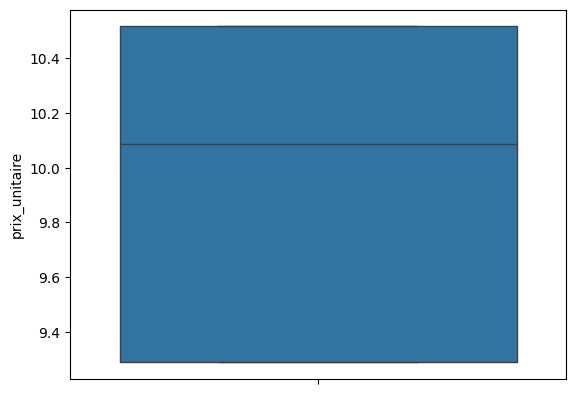

In [ ]:
'''
id_produit
categorie
marque
prix_unitaire
promotion
jour_ferie
weekend
stock_disponible
condition_meteo
region
moment_journee
quantite_vendue
month
day
quarter
promotion_stock_ratio
id_number
id_month
id_year
'''

import seaborn as sns
jj = op_4_train_df.copy()
sns.boxplot(jj['prix_unitaire'])

In [ ]:
models_best_params = {
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            'n_estimators': 200, 'learning_rate': 0.1405101551254267, 'max_depth': 3, 'subsample': 0.9726700223015472, 'colsample_bytree': 0.9677476502226031, 'alpha': 0, 'reg_lambda': 10
        }
    }
}


from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error

# Define the KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each model in models_best_params
for model_name, params in models_best_params.items():
  model = params["model"]
  param_dict = params["params"]

  if model_name != "CatBoost":
    model.set_params(**param_dict)

  fold_scores = []  # Initialize this for each model
  custom_fold_scores = []  # Initialize this for each model

  print(f"======================== Starting cross-validation for {model_name} ========================")

  # Perform cross-validation
  for i, (train_index, test_index) in enumerate(kf.split(X_train)):
      X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
      y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

      # Set the best parameters directly

      # Train the model with the training fold data
      best_model = model.fit(X_train_fold, y_train_fold)

      # Predict on the test fold
      y_pred = np.floor(best_model.predict(X_test_fold))
      y_pred_custom = round_custom(y_pred)

      # Calculate MAPE for this fold and store it
      fold_mape = mape_function(y_test_fold, y_pred)
      fold_mape_custom = mape_function(y_test_fold, y_pred_custom)

      fold_scores.append(fold_mape)
      custom_fold_scores.append(fold_mape_custom)
      # Print MAPE for this fold
      print(f"Fold [{i}] =====> MAPE FLOOR: {fold_mape} ||||||||| MAPE CUSTOM {fold_mape_custom}")

  # Calculate the mean MAPE for this model across all folds
  mean_fold_mape = np.mean(fold_scores)
  print(f"{model_name} - Mean MAPE FLOOR across folds: {mean_fold_mape} |||||||| CUSTOM {np.mean(custom_fold_scores)}")
  print("="*80)

  # After cross-validation, retrain the best model on the full training data
  best_model = model.fit(X_train, y_train)  # Retrain on the entire training set

  # Get predictions from the model on the test or validation set
  y_pred_final = np.floor(best_model.predict(X_test)) # or X_valid if using a validation set

  # Calculate and print the final MAPE on the test/validation set
  final_mape = mape_function(y_test, y_pred_final)  # or y_valid if using a validation set
  print(f"{model_name} - Final MAPE on the test set: (FLOOR) {final_mape}")
  print("\n")
  print("="*80)


======================== Starting cross-validation for XGBoost ========================
Fold [0] =====> MAPE FLOOR: 0.23875537592363957 ||||||||| MAPE CUSTOM 0.23875537592363957
Fold [1] =====> MAPE FLOOR: 0.23632982165625088 ||||||||| MAPE CUSTOM 0.23632982165625088
Fold [2] =====> MAPE FLOOR: 0.22952706659194164 ||||||||| MAPE CUSTOM 0.22952706659194164
Fold [3] =====> MAPE FLOOR: 0.2328422330297374 ||||||||| MAPE CUSTOM 0.2328422330297374
Fold [4] =====> MAPE FLOOR: 0.23644529050298882 ||||||||| MAPE CUSTOM 0.23644529050298882
XGBoost - Mean MAPE FLOOR across folds: 0.23477995754091166 |||||||| CUSTOM 0.23477995754091166
XGBoost - Final MAPE on the test set: (FLOOR) 0.25360582158746625




In [ ]:
from sklearn.linear_model import QuantileRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Train Quantile Regression (LAD Regression corresponds to quantile=0.5)
quantile_model = QuantileRegressor(quantile=0.5, alpha=0.01)
quantile_model.fit(X_train, y_train)

# Predict
y_pred = quantile_model.predict(X_test)

# Evaluate
mae = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAE (Quantile Regression): {mae:.4f}")


NameError: name 'X_train' is not defined

# Submissions

In [ ]:
y_sub = np.floor(model.predict(op_4_sub_df))
y_sub_df = pd.DataFrame({
    "id": range(1, len(y_sub) + 1),
    "quantite_vendue": y_sub
})

y_sub_df.to_csv("subVF2.csv", index=False)